# ViPlan: A Benchmark for Visual Planning with Symbolic Predicates and Vision-Language Models

This notebook is designed to extract the results from the ViPlan benchmark and replicate the Figures and Tables from the paper. 

## Results Folder Structure

When launching a job using the provided SLURM scripts, this will be the folder structure of the results:

```
results/
├── planning/
│   ├── blocksworld/
│   │   ├── experiment_name/
│   │   │   ├── split/
│   │   │   │   ├── model_name/
│   │   │   │   |   ├── results_slurmid.json
│   ├── igibson/
│   │   ├── experiment_name/
│   │   │   ├── split/
│   │   │   │   ├── model_name/
│   │   │   │   |   ├── results_slurmid.json
```

From this, the notebook can load all the results and display them.

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

ROOT = os.path.dirname(os.path.abspath('.'))
print("ROOT", ROOT)

ROOT /scratch/cs/world-models/merlerm1/ViPlan


In [2]:
sys.path.append(ROOT)

In [3]:
ROUNDING = 2 # number of decimal places to round to

In [4]:
SAVE_FIGURES = True # Set to False to not save figures to disk

In [5]:
FIGURES_FOLDER = os.path.join(ROOT, 'results', 'figures')
if not os.path.exists(FIGURES_FOLDER):
    os.makedirs(FIGURES_FOLDER)

def save_fig(fig, name):
    if not name.lower().endswith('.pdf'):
        name = f"{name}.pdf"
    fig.savefig(
        os.path.join(FIGURES_FOLDER, name),
        format='pdf',
        bbox_inches='tight',
        dpi=300
    )
    plt.close(fig)

In [6]:
# Matplotlib settings

plt.rcParams.update({
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold'
})


## Models

In [7]:
expected_models = set([
    "gpt-4.1-nano",
    "gpt-4.1",
    "llava-onevision-qwen2-7b-ov-hf",
    "llava-onevision-qwen2-72b-ov-hf",
    "Qwen2.5-VL-7B-Instruct",
    "Qwen2.5-VL-72B-Instruct",
    "InternVL3-8B",
    "InternVL3-78B",
    "gemma-3-12b-it",
    "gemma-3-27b-it",
    "aya-vision-32b",
    "aya-vision-8b",
    "Molmo-7B-D-0924",
    "Phi-4-multimodal-instruct",
    "Mistral-Small-3.1-24B-Instruct-2503",
    "deepseek-vl2",
])

readable_model_names = {
    "gpt-4.1-nano": "GPT-4.1 Nano",
    "gpt-4.1": "GPT-4.1",
    "llava-onevision-qwen2-7b-ov-hf": "LLaVA-Onevision 7B",
    "llava-onevision-qwen2-72b-ov-hf": "LLaVA-Onevision 72B",
    "Qwen2.5-VL-7B-Instruct": "Qwen2.5-VL 7B",
    "Qwen2.5-VL-72B-Instruct": "Qwen2.5-VL 72B",
    "InternVL3-8B": "InternVL3 8B",
    "InternVL3-78B": "InternVL3 78B",
    "gemma-3-12b-it": "Gemma-3 12B",
    "gemma-3-27b-it": "Gemma-3 27B",
    "aya-vision-32b": "AyaVision 32B",
    "aya-vision-8b": "AyaVision 8B",
    "Molmo-7B-D-0924": "Molmo 7B",
    "Phi-4-multimodal-instruct": "Phi-4 Multimodal",
    "Mistral-Small-3.1-24B-Instruct-2503": "Mistral-Small-3.1 24B",
    "deepseek-vl2": "DeepSeek-VL2",
}

color_map = {
    "llava-onevision-qwen2-7b-ov-hf": "#A569BD",
    "llava-onevision-qwen2-72b-ov-hf": "#6A0DAD",
    "Qwen2.5-VL-7B-Instruct": "#AEC7E8",
    "Qwen2.5-VL-72B-Instruct": "#1F77B4",
    "aya-vision-8b": "#98DF8A",
    "aya-vision-32b": "#2CA02C",
    "gemma-3-12b-it": "#e2f78b",
    "gemma-3-27b-it": "#ccff00",
    "deepseek-vl2": "#7F7F7F",
    "Phi-4-multimodal-instruct": "#FFD700",
    "Molmo-7B-D-0924": "#E377C2",
    "Mistral-Small-3.1-24B-Instruct-2503": "#FF7F0E",
    "InternVL3-8B": "#FF9896",
    "InternVL3-78B": "#D62728",
    "gpt-4.1": "#17A2B8",
    "gpt-4.1-nano": "#9ad9e3",
}

vlm_models_by_size = {
    "small": [
        "deepseek-vl2",                    # ~4.5B (activated)
        "Phi-4-multimodal-instruct",       # ~5.6B
        "Molmo-7B-D-0924",                 # 7B
        "llava-onevision-qwen2-7b-ov-hf",  # 7B
        "Qwen2.5-VL-7B-Instruct",          # 7B
        "aya-vision-8b",                   # 8B
        "InternVL3-8B",                    # 8B
    ],
    "medium": [
        "gemma-3-12b-it",                       # 12B
        "Mistral-Small-3.1-24B-Instruct-2503",  # 24B
        "gemma-3-27b-it",                       # 27B
        "aya-vision-32b",                       # 32B
    ],
    "large": [
        "llava-onevision-qwen2-72b-ov-hf", # 72B
        "Qwen2.5-VL-72B-Instruct",         # 72B
        "InternVL3-78B",                   # 78B
    ],
    "closed_models": [
        "gpt-4.1",
        "gpt-4.1-nano",
    ]
}

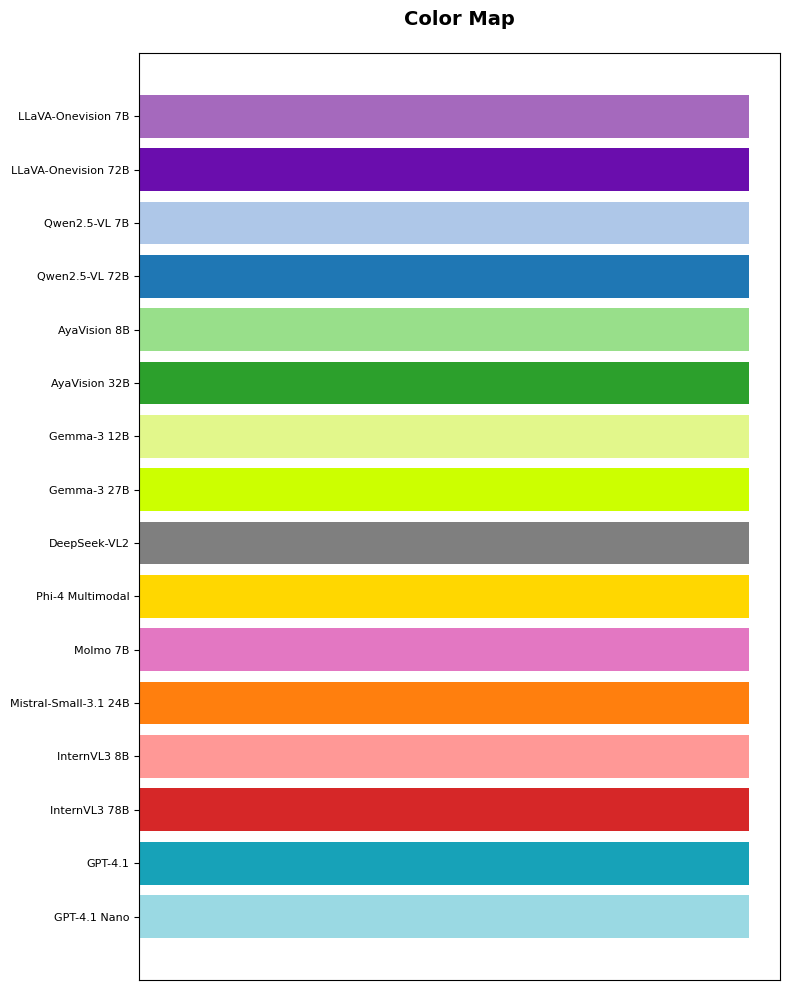

In [8]:
model_names = list(color_map.keys())
colors = list(color_map.values())
y_positions = range(len(model_names))
readable_names = [readable_model_names.get(name, name) for name in model_names]

fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(y_positions, [1] * len(model_names), color=colors)
ax.set_yticks(y_positions)
ax.set_yticklabels(readable_names, fontsize=8)
ax.invert_yaxis()
ax.set_xticks([])
ax.set_title('Color Map', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Loading the Results

In [9]:
# Blocksworld results without CoT
blocksworld_no_cot_experiment = os.path.join(ROOT, 'results', 'final', 'blocksworld', 'final_no_cot')
# Blocksworld results with CoT
blocksworld_cot_experiment = os.path.join(ROOT, 'results', 'final', 'blocksworld', 'final_cot')

# Blocksworld with action failure probability 0.1 (no CoT)
blocksworld_fail0_1_experiment = os.path.join(ROOT, 'results', 'final', 'blocksworld', 'final_fail01_no_cot')

# iGibson results without CoT
igibson_no_cot_experiment = os.path.join(ROOT, 'results', 'final', 'igibson', 'final_no_cot')
# iGibson results with CoT
igibson_cot_experiment = os.path.join(ROOT, 'results', 'final', 'igibson', 'final_cot')

In [10]:
splits = ['simple', 'medium', 'hard']

In [11]:
def load_results(experiment_folder):
    def _load(folder):
        assert os.path.exists(folder), f"{folder} does not exist"
        results = defaultdict(dict)
        for split in splits:
            results[split] = defaultdict(dict)
            split_folder = os.path.join(folder, split)
            if not os.path.exists(split_folder):
                print(f"Split folder {split_folder} does not exist")
                continue
            for model in os.listdir(split_folder):
                model_folder = os.path.join(split_folder, model)
                contents = os.listdir(model_folder)
                if not contents:
                    print(f"Model folder {model_folder} is empty")
                    continue
                if len(contents) > 1:
                    print(f"Model folder {model_folder} has more than one file, defaulting to most recent")
                latest = sorted(contents)[-1]
                with open(os.path.join(model_folder, latest)) as f:
                    results[split][model] = json.load(f)
        return results

    predicates_folder = os.path.join(experiment_folder, 'predicates')
    vila_folder       = os.path.join(experiment_folder, 'vila')

    pred_results = _load(predicates_folder)
    vila_results = _load(vila_folder)
    return pred_results, vila_results

blocksworld_no_cot_pred, blocksworld_no_cot_vila = load_results(blocksworld_no_cot_experiment)
blocksworld_cot_pred, blocksworld_cot_vila = load_results(blocksworld_cot_experiment)
blocksworld_fail0_1_pred, blocksworld_fail0_1_vila = load_results(blocksworld_fail0_1_experiment)
igibson_no_cot_pred, igibson_no_cot_vila = load_results(igibson_no_cot_experiment)
igibson_cot_pred, igibson_cot_vila = load_results(igibson_cot_experiment)


Model folder /scratch/cs/world-models/merlerm1/ViPlan/results/final/blocksworld/final_no_cot/predicates/simple/gpt-4.1-nano has more than one file, defaulting to most recent
Model folder /scratch/cs/world-models/merlerm1/ViPlan/results/final/blocksworld/final_cot/predicates/simple/Molmo-7B-D-0924 has more than one file, defaulting to most recent
Model folder /scratch/cs/world-models/merlerm1/ViPlan/results/final/blocksworld/final_cot/vila/hard/gemma-3-27b-it has more than one file, defaulting to most recent


As all the results are in separate dicts, it is easier to convert them to a single merged dataframe for plotting:

In [12]:
def construct_predicates_table(results):
    rows = []
    for split in splits:
        for model, data in results.get(split, {}).items():
            # Safely round metrics, leaving NaN as is
            ta = results.get(split, {})[model].get('task_accuracy', np.nan)
            aa = results.get(split, {})[model].get('action_accuracy', np.nan)
            pa = results.get(split, {})[model].get('predicate_accuracy', np.nan)
            mpa = results.get(split, {})[model].get('macro_predicate_accuracy', np.nan)
            fr = results.get(split, {})[model].get('fail_ratio', np.nan)
            
            problem_keys = [p for p in data.keys() if '.pddl' in str(p)]
            # Find how many questions were asked for the accuracy error
            prediction_count = 0
            for problem in problem_keys:
                # Initial enumeration
                initial_enum = data[problem].get('initial_state_enum', {}).get('statistics', {})
                prediction_count += initial_enum.get('yes_total', 0)
                prediction_count += initial_enum.get('no_total', 0)
                # Replanning enumeration
                replans = data[problem].get('replans', [])
                if replans is None: replans = []
                for replan in replans:
                    replan_enum = replan.get('enum_metrics', {})
                    prediction_count += replan_enum.get('yes_total', 0)
                    prediction_count += replan_enum.get('no_total', 0)
                # Actions
                actions = data[problem].get('action_results', [])
                if actions is None: actions = []
                for action in actions:
                    precondition_results = action.get('precondition_results', {})
                    prediction_count += len( [k for k in precondition_results.keys() if k not in ['all_correct', 'all_state_correct'] ] )
                    effect_results = action.get('effect_results', {})
                    prediction_count += len( [k for k in effect_results.keys() if k not in ['all_correct', 'all_state_correct'] ] )
            
            rows.append({
                'model': model,
                'split': split,
                'predicate accuracy': np.nan if pd.isna(pa) else round(pa, ROUNDING),
                'macro predicate accuracy': np.nan if pd.isna(mpa) else round(mpa, ROUNDING),
                'action accuracy': np.nan if pd.isna(aa) else round(aa, ROUNDING),
                'task accuracy': np.nan if pd.isna(ta) else round(ta, ROUNDING),
                'starting ratio': np.nan if pd.isna(1-fr) else round(1-fr, ROUNDING),
                'problem_count': len(problem_keys),
                'prediction_count': prediction_count,
            })
            
    df = pd.DataFrame(rows)
    df['split'] = pd.Categorical(df['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df = df.sort_values(by=['model', 'split'])
    return df

def construct_vila_table(results):
    rows = []
    for split in splits:
        for model, data in results.get(split, {}).items():
            problem_keys = [k for k in data.keys() if isinstance(data[k], dict) and 'actions' in data[k]]
            avg_plan_length = np.mean([len(data[k]['actions']) for k in problem_keys])
            avg_success_plan_length = np.mean([len(data[k]['actions']) for k in problem_keys if data[k]['completed']])
            rows.append({
                'model': model,
                'split': split,
                'avg_plan_length': avg_plan_length,
                'avg_success_plan_length': avg_success_plan_length,
                'problem_count': len(problem_keys),
                **data['statistics']
            })
    df = pd.DataFrame(rows)
    df['split'] = pd.Categorical(df['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df = df.sort_values(by=['model', 'split'])
    return df

In [13]:
blocksworld_no_cot_pred_df = construct_predicates_table(blocksworld_no_cot_pred)
blocksworld_no_cot_vila_df = construct_vila_table(blocksworld_no_cot_vila)

blocksworld_cot_pred_df = construct_predicates_table(blocksworld_cot_pred)
blocksworld_cot_vila_df = construct_vila_table(blocksworld_cot_vila)

blocksworld_fail0_1_pred_df = construct_predicates_table(blocksworld_fail0_1_pred)
blocksworld_fail0_1_vila_df = construct_vila_table(blocksworld_fail0_1_vila)

igibson_no_cot_pred_df = construct_predicates_table(igibson_no_cot_pred)
igibson_no_cot_vila_df = construct_vila_table(igibson_no_cot_vila)

igibson_cot_pred_df = construct_predicates_table(igibson_cot_pred)
igibson_cot_vila_df = construct_vila_table(igibson_cot_vila)

/home/merlerm1/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/merlerm1/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/merlerm1/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/merlerm1/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/merlerm1/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/merlerm1/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar 

### Models check

In [14]:
def list_models(results):
    """
    List the models in the results.
    """
    models = {split: set() for split in splits}
    
    for split in splits:
        for model in results[split]:
            models[split].add(model)
                
    # Check if all expected models are present
    for split in splits:
        missing_models = expected_models - models[split]
        if len(missing_models) > 0:
            print(f"Missing models in {split}: {missing_models}")
        else:
            print(f"All expected models are present in {split}")
    
    return models

In [15]:
print("Blocksworld no CoT predicates")
models_blocksworld_pred_no_cot = list_models(blocksworld_no_cot_pred)
print()
print("Blocksworld CoT predicates")
models_blocksworld_pred_cot = list_models(blocksworld_cot_pred)
print()
print("Blocksworld no CoT VILA")
models_blocksworld_vila_no_cot = list_models(blocksworld_no_cot_vila)
print()
print("Blocksworld CoT VILA")
models_blocksworld_vila_cot = list_models(blocksworld_cot_vila)
print()
print("Blocksworld fail 0.1 predicates")
models_blocksworld_fail0_1_pred = list_models(blocksworld_fail0_1_pred)
print()
print("Blocksworld fail 0.1 VILA")
models_blocksworld_fail0_1_vila = list_models(blocksworld_fail0_1_vila)
print()
print("iGibson no CoT predicates")
models_igibson_pred_no_cot = list_models(igibson_no_cot_pred)
print()
print("iGibson CoT predicates")
models_igibson_pred_cot = list_models(igibson_cot_pred)
print()
print("iGibson no CoT VILA")
models_igibson_vila_no_cot = list_models(igibson_no_cot_vila)
print()
print("iGibson CoT VILA")
models_igibson_vila_cot = list_models(igibson_cot_vila)

Blocksworld no CoT predicates
All expected models are present in simple
All expected models are present in medium
All expected models are present in hard

Blocksworld CoT predicates
All expected models are present in simple
All expected models are present in medium
All expected models are present in hard

Blocksworld no CoT VILA
All expected models are present in simple
All expected models are present in medium
All expected models are present in hard

Blocksworld CoT VILA
All expected models are present in simple
All expected models are present in medium
All expected models are present in hard

Blocksworld fail 0.1 predicates
Missing models in simple: {'gpt-4.1'}
Missing models in medium: {'gpt-4.1'}
Missing models in hard: {'gpt-4.1'}

Blocksworld fail 0.1 VILA
Missing models in simple: {'gpt-4.1'}
Missing models in medium: {'gpt-4.1'}
Missing models in hard: {'gpt-4.1'}

iGibson no CoT predicates
All expected models are present in simple
All expected models are present in medium
All 

## Figures

### VLM-as-grounder vs VLM-as-planner

In [16]:
from matplotlib.patches import Patch

def plot_evaluation_settings_comparison(blocksworld_pred_df, blocksworld_vila_df, igibson_pred_df, igibson_vila_df, save=SAVE_FIGURES):

    grounder_color = np.array([244/255, 99/255, 103/255]) 
    planner_color  = np.array([68/255, 166/255, 216/255])

    # flatten models by size
    size_order = list(vlm_models_by_size.keys())
    models = [m for size in size_order for m in vlm_models_by_size[size]]
    readable_names = [readable_model_names.get(m, m) for m in models]
    x = np.arange(len(models))

    methods = ['VLM-as-grounder', 'VLM-as-planner']
    split_alphas = {'simple': 0.2, 'medium': 0.4, 'hard': 0.8}
    bar_width = 0.35
    offsets = {'VLM-as-grounder': -bar_width/2, 'VLM-as-planner': bar_width/2}

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

    configs = [
        (blocksworld_pred_df, blocksworld_vila_df, "ViPLan-BW"),
        (igibson_pred_df, igibson_vila_df, "ViPLan-HH"),
    ]

    for ax, (pred_table, vila_table, title) in zip(axes, configs):
        for method in methods:
            dfm, col = (
                (pred_table, 'task accuracy')
                if method == 'VLM-as-grounder'
                else (vila_table,  'task_completion_rate')
            )
            for split in splits:
                vals = [
                    (
                        dfm[(dfm.model == m) & (dfm.split == split)][col]
                        .iloc[0]
                        if not dfm[(dfm.model == m) & (dfm.split == split)].empty
                        else np.nan
                    )
                    for m in models
                ]
                ax.bar(
                    x + offsets[method], vals,
                    width=bar_width,
                    color=[grounder_color if method == 'VLM-as-grounder' else planner_color] * len(models),
                    edgecolor='black',
                    alpha=split_alphas[split],
                )
        ax.set_title(title, fontsize=18)
        ax.set_ylabel("Success Rate", fontsize=16)
        ax.set_xticks(x)
        if ax is axes[0]:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(readable_names, rotation=45, ha='right', fontsize=14)
        ax.tick_params(axis='y', labelsize=12)

    # draw separators and size-group labels at the top of the plot
    counts = [len(vlm_models_by_size[size]) for size in size_order]
    cum_counts = np.cumsum(counts)
    group_centers = np.cumsum([0] + counts[:-1]) + np.array(counts) / 2

    size_order_str = ["small models", "medium models", "large models", "closed models"]
    for ax in axes:
        for boundary in cum_counts[:-1]:
            ax.axvline(x=boundary - 0.5, color='gray', linestyle=':')

        y_max = ax.get_ylim()[1]
        for size_label, center in zip(size_order_str, group_centers):
            ax.text(
                x=center,
                y=y_max * 0.95,
                s=size_label,
                ha='right' if size_label != "closed models" else 'center',
                va='top',
                fontsize=12,
                fontweight='light',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2)
            )

    method_handles = [
        Patch(facecolor=grounder_color, edgecolor='black', label='VLM-as-grounder'),
        Patch(facecolor=planner_color, edgecolor='black', label='VLM-as-planner'),
    ]
    split_handles = [
        Patch(facecolor='gray', edgecolor='black', alpha=split_alphas[s], label=s.capitalize())
        for s in splits
    ]
    handles = method_handles + split_handles

    fig.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.04),
        ncol=len(handles),
        fontsize=14
    )
    plt.tight_layout()
    plt.show()
    if save:
        save_fig(fig, "evaluation_settings_comparison")


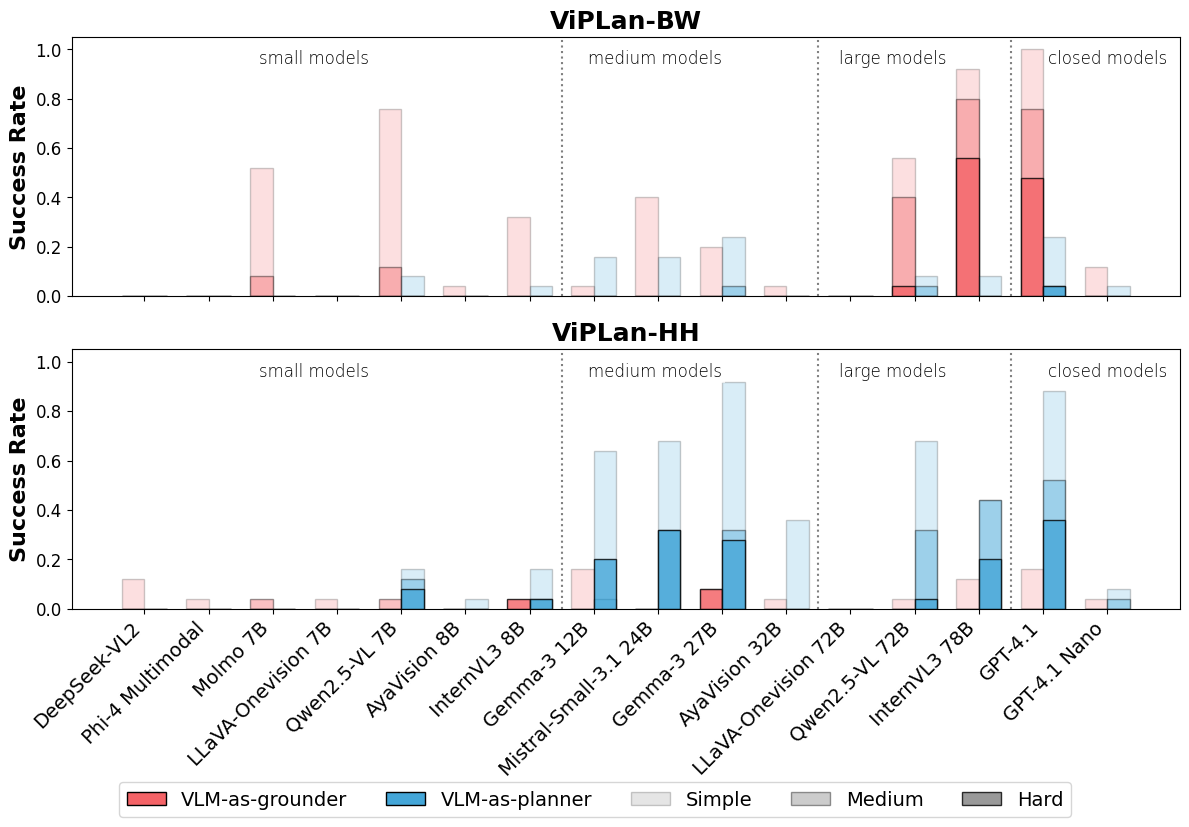

In [17]:
plot_evaluation_settings_comparison(
    blocksworld_no_cot_pred_df,
    blocksworld_no_cot_vila_df,
    igibson_no_cot_pred_df,
    igibson_no_cot_vila_df,
    save=SAVE_FIGURES
)

### Required Predictions VS Solved Tasks

Only for Blocksworld at the moment, for iGibson it takes longer to extract the oracle data so there is a script for that.

In [18]:
from tqdm import tqdm

# Functions are hardcoded to use blocksworld_no_cot_pred, switch to cot if needed

plot_data = { }
for model in tqdm(expected_models):
    found_something = False
    for split in splits:
        results_tmp = blocksworld_no_cot_pred[split][model]
        problems = [key for key in results_tmp if key.endswith('.pddl')]
        for problem in problems:
            solved = results_tmp[problem].get('goal_reached', False)
            actions = results_tmp[problem].get('action_results', [])
            if actions is None:
                continue
            predictions = 0
            found_something = True
            for action in actions:
                precond_results = action['preconditions_results']
                precond_predictions = len([ key for key in precond_results if key not in ['all_correct', 'all_state_correct'] ])
                predictions += precond_predictions
                
                effect_results = action['effects_results']
                if effect_results is None:
                    continue
                effect_predictions = len([ key for key in effect_results if key not in ['all_correct', 'all_state_correct'] ])
                predictions += effect_predictions
            
            if problem not in plot_data:
                plot_data[problem] = {}
            plot_data[problem][model] = {
                'predictions': predictions,
                'solved': solved,
                'actions': len(actions),
            }

100%|██████████| 16/16 [00:00<00:00, 1194.70it/s]


Let's compute the number of required oracle predictions from each problem using the simulator (can be done on CPU as no rendering is needed).

In [19]:
import copy
from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from viplan.experiments.benchmark_blocksworld_plan import get_preconditions_predicates, get_effects_predicates
from viplan.code_helpers import get_logger

from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader

unified_planning.shortcuts.get_environment().credits_stream = None # Disable planner printouts


DOMAIN_FILE = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'domain.pddl')

def get_oracle_predictions(problem_file):
    
    problem = PDDLReader().parse_problem(DOMAIN_FILE, os.path.join(ROOT, problem_file))
    with OneshotPlanner(problem_kind=problem.kind) as planner:
        result = planner.solve(problem)
    plan = result.plan
    
    predictions = 0
    env = BlocksworldSimulator(problem, root_path=ROOT, seed=1, logger=get_logger('error'))
    env.reset()
    for action in plan.actions:
        grounded_args = {param.name: str(value) for param, value in zip(action.action.parameters, action.actual_parameters)}

        preconditions = action.action.preconditions
        previous_state = copy.deepcopy(env.state)
        precond_preds = get_preconditions_predicates(preconditions, grounded_args)
        predictions += len(precond_preds)
        legal, info = env.apply_action(action)
        assert legal == True, f"Action {action.action.name} failed: {info}"
        effects = action.action.effects
        effects_preds = get_effects_predicates(env, effects, grounded_args, previous_state)
        predictions += len(effects_preds)
    return predictions, len(plan.actions)

for problem_file in tqdm(plot_data):
    predictions, actions = get_oracle_predictions(problem_file)
    plot_data[problem_file]['oracle_predictions'] = predictions
    plot_data[problem_file]['oracle_actions'] = actions

/home/merlerm1/.local/lib/python3.12/site-packages/google/protobuf/runtime_version.py:112: UserWarning: Protobuf gencode version 5.27.2 is older than the runtime version 5.28.0 at unified_planning.proto. Please avoid checked-in Protobuf gencode that can be obsolete.
  warnings.warn(
100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


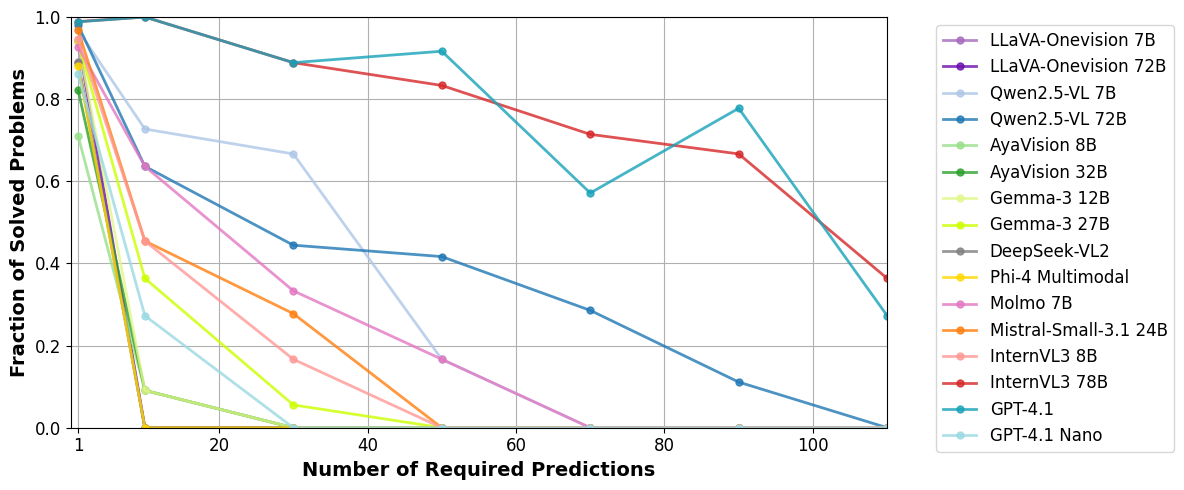

In [20]:
problems = list(plot_data.keys())
oracle_preds = np.array([plot_data[p]['oracle_predictions'] for p in problems])

bin_size = 20 # change for finer or coarser granularity
bins = np.arange(0, oracle_preds.max() + bin_size, bin_size)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = np.insert(bin_centers, 0, 1)
models_sorted = [m for m in color_map.keys() if m in expected_models]

# smoothing toggle (Figure in the paper does not use smoothing)
apply_smoothing = False   # set to False to plot raw fractions
smooth_window = 3         # rolling window size

fig, ax = plt.subplots(figsize=(12, 5))

plot_lines = []
for model in models_sorted:
    solved_model = np.array(
        [plot_data[p].get(model, {}).get('solved', False) for p in problems],
        dtype=int
    )
    fractions = []
    for left, right in zip(bins[:-1], bins[1:]):
        mask = (oracle_preds >= left) & (oracle_preds < right)
        fractions.append(solved_model[mask].mean() if mask.any() else np.nan)

    predicate_accuracy = []
    for split in splits:
        if model not in blocksworld_no_cot_pred[split]:
            continue
        predicate_accuracy.append(blocksworld_no_cot_pred[split][model].get('predicate_accuracy', np.nan))
    predicate_accuracy = np.nanmean(predicate_accuracy)
    fractions = [predicate_accuracy] + fractions

    frac_series = pd.Series(fractions)
    smooth_frac = (
        frac_series
        .interpolate()
        .rolling(window=smooth_window, min_periods=1, center=True)
        .mean()
    ) if apply_smoothing else frac_series

    line, = ax.plot(
        bin_centers,
        smooth_frac,
        linewidth=2,
        alpha=0.8,
        marker='o',
        markersize=5,
        color=color_map[model]
    )
    plot_lines.append(line)

legend_labels = [readable_model_names.get(m, m) for m in models_sorted]
ax.set_xlabel('Number of Required Predictions', fontsize=14)
ax.set_ylabel('Fraction of Solved Problems', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(0, 1)
ax.set_xlim(0, bin_centers.max())
ax.set_xticks([1, 20, 40, 60, 80, 100])
ax.grid(True)
ax.legend(plot_lines, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

fig.tight_layout()
plt.show()

if SAVE_FIGURES:
    save_fig(fig, "blocksworld_predictions_vs_solved")


### No CoT vs CoT

Computing CoT differences for Blocksworld
Average for simple (grounder): -0.06 with error 0.0216 (ratio 2.78)
Average for simple (planner): 0.0525 with error 0.0175 (ratio 3.0)
Average for medium (grounder): -0.0175 with error 0.0147 (ratio 1.19)
Average for medium (planner): 0.0325 with error 0.0089 (ratio 3.65)
Average for hard (grounder): -0.005 with error 0.0127 (ratio 0.39)
Average for hard (planner): 0.0075 with error 0.0053 (ratio 1.42)

Computing CoT differences for iGibson
Average for simple (grounder): 0.01 with error 0.0157 (ratio 0.64)
Average for simple (planner): -0.0675 with error 0.024 (ratio 2.81)
Average for medium (grounder): 0.0 with error 0.0049 (ratio 0.0)
Average for medium (planner): -0.065 with error 0.0184 (ratio 3.53)
Average for hard (grounder): -0.0025 with error 0.0054 (ratio 0.46)
Average for hard (planner): -0.04 with error 0.0167 (ratio 2.4)


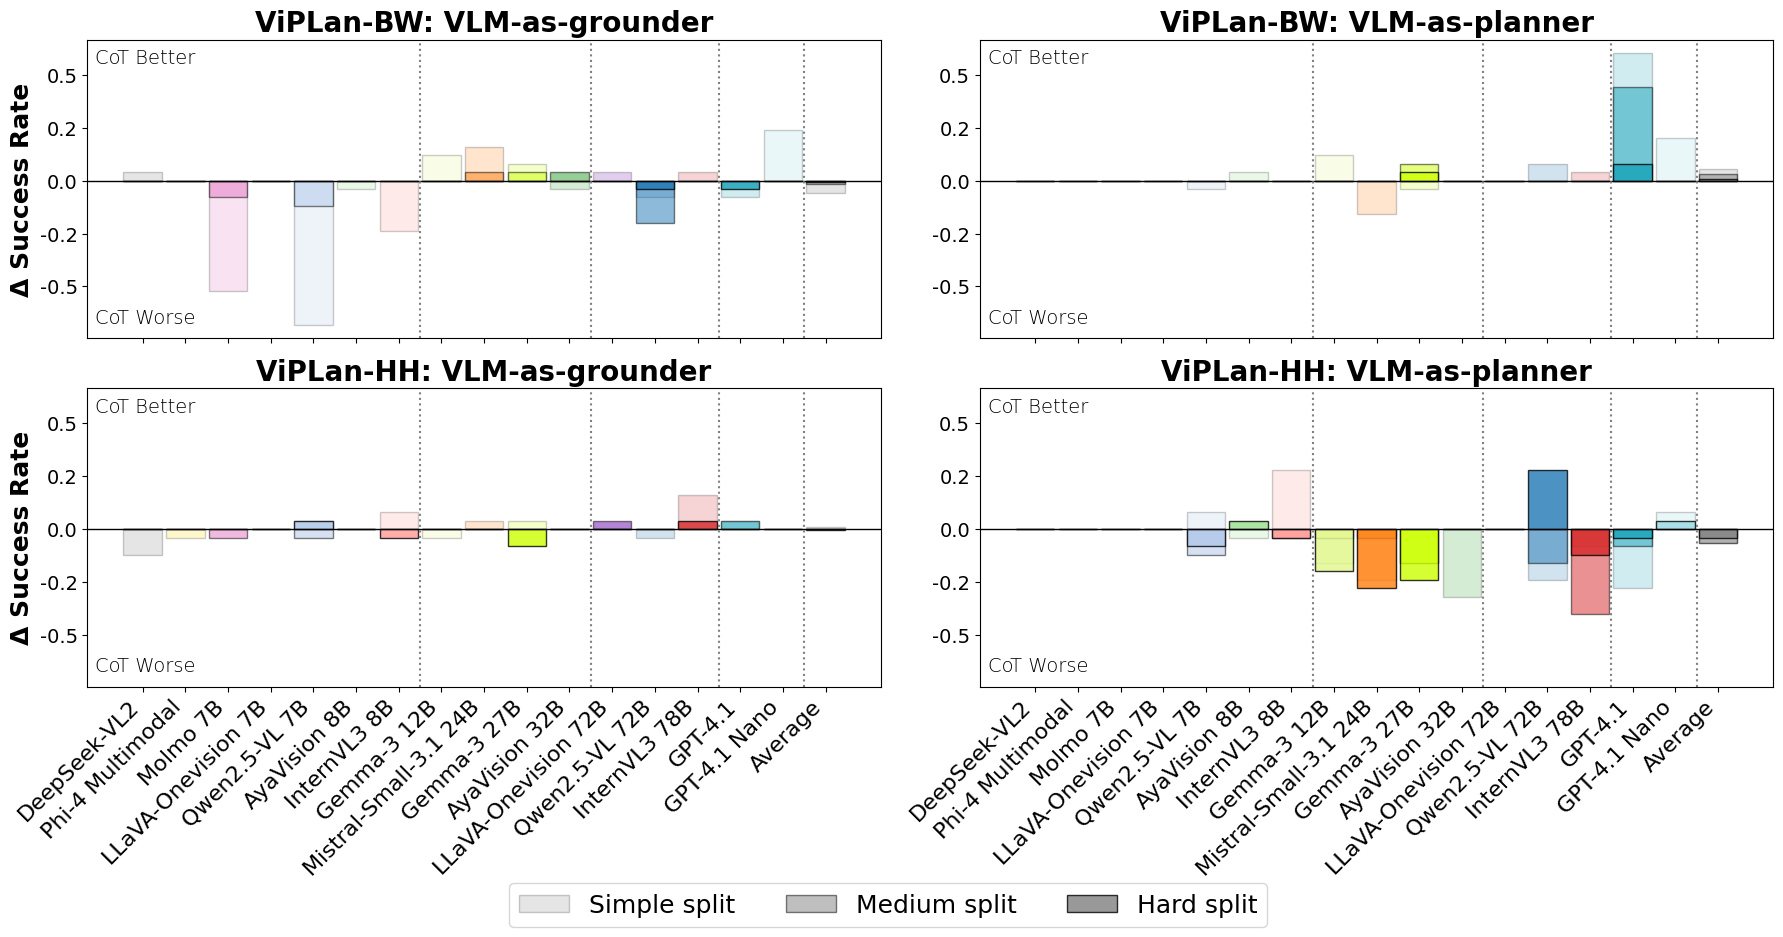

In [21]:
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter

def compute_cot_diff(pred_no_cot, pred_cot, vila_no_cot, vila_cot):
    pred_no_cot["error_no"] = np.sqrt(
        pred_no_cot['task accuracy'] * (1 - pred_no_cot['task accuracy']) / pred_no_cot["problem_count"]
    )
    pred_cot["error_cot"] = np.sqrt(
        pred_cot['task accuracy'] * (1 - pred_cot['task accuracy']) / pred_cot["problem_count"]
    )
    vila_no_cot["error_no"] = np.sqrt(
        vila_no_cot['task_completion_rate'] * (1 - vila_no_cot['task_completion_rate']) / vila_no_cot["problem_count"]
    )
    vila_cot["error_cot"] = np.sqrt(
        vila_cot['task_completion_rate'] * (1 - vila_cot['task_completion_rate']) / vila_cot["problem_count"]
    )
    
    df_grounder = pd.merge(
        pred_no_cot[['model','split','task accuracy','error_no']].rename(columns={'task accuracy':'no'}),
        pred_cot[['model','split','task accuracy', 'error_cot']].rename(columns={'task accuracy':'cot'}),
        on=['model','split']
    )
    df_grounder['diff'] = df_grounder['cot'] - df_grounder['no']
    
    # Propagate standard error
    df_grounder['error'] = np.sqrt(
        df_grounder['error_no']**2 + df_grounder['error_cot']**2
    )
    df_grounder['error'] = df_grounder['error'].round(4)
    df_grounder['diff'] = df_grounder['diff'].round(4)
    
    df_planner = pd.merge(
        vila_no_cot[['model','split','task_completion_rate', 'error_no']].rename(columns={'task_completion_rate':'no'}),
        vila_cot[['model','split','task_completion_rate', 'error_cot']].rename(columns={'task_completion_rate':'cot'}),
        on=['model','split']
    )
    df_planner['diff'] = df_planner['cot'] - df_planner['no']
    
    # Propagate standard error
    df_planner['error'] = np.sqrt(
        df_planner['error_no']**2 + df_planner['error_cot']**2
    )
    df_planner['error'] = df_planner['error'].round(4)
    df_planner['diff'] = df_planner['diff'].round(4)
    
    # Compute the average error across all models for each split. Add it to the dataframe with a new row with model name "Average"
    # To compute the mean standard error, we use the formula for the propagation of uncertainty for independent variables:
    # error = sqrt(error1^2 + error2^2 + ... + errorN^2) / N
    # where error1, error2, ..., errorN are the standard errors of each model.
    
    table_data = {}
    for split in splits:
        avg_grounder = df_grounder[df_grounder['split'] == split]['diff'].mean()
        avg_error_grounder = np.sqrt((df_grounder[df_grounder['split'] == split]['error']**2).sum()) / len(df_grounder[df_grounder['split'] == split])
        avg_grounder = round(avg_grounder, 4)
        avg_error_grounder = round(avg_error_grounder, 4)
        df_grounder = pd.concat([
            df_grounder,
            pd.DataFrame([{
            'model': 'Average',
            'split': split,
            'diff': avg_grounder,
            'error': avg_error_grounder
            }])
        ], ignore_index=True)
        
        ratio_grounder = round(abs(avg_grounder / avg_error_grounder), ROUNDING)
        print(f"Average for {split} (grounder): {avg_grounder} with error {avg_error_grounder} (ratio {ratio_grounder})")

        avg_planner = df_planner[df_planner['split'] == split]['diff'].mean()
        avg_error_planner = np.sqrt((df_planner[df_planner['split'] == split]['error']**2).sum()) / len(df_planner[df_planner['split'] == split])
        avg_planner = round(avg_planner, 4)
        avg_error_planner = round(avg_error_planner, 4)
        df_planner = pd.concat([
            df_planner,
            pd.DataFrame([{
            'model': 'Average',
            'split': split,
            'diff': avg_planner,
            'error': avg_error_planner
            }])
        ], ignore_index=True)
        
        ratio_planner = round(abs(avg_planner / avg_error_planner), ROUNDING)
        print(f"Average for {split} (planner): {avg_planner} with error {avg_error_planner} (ratio {ratio_planner})")
        table_data[split] = {
            'grounder': {
                'avg': avg_grounder,
                'error': avg_error_grounder,
                'ratio': ratio_grounder
            },
            'planner': {
                'avg': avg_planner,
                'error': avg_error_planner,
                'ratio': ratio_planner
            }
        }

    df_grounder['split'] = pd.Categorical(df_grounder['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df_planner['split'] = pd.Categorical(df_planner['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    
    return df_grounder, df_planner, table_data

print("Computing CoT differences for Blocksworld")
df_grounder_diff_blocks, df_planner_diff_blocks, table_data_blocks = compute_cot_diff(
    blocksworld_no_cot_pred_df, blocksworld_cot_pred_df,
    blocksworld_no_cot_vila_df,  blocksworld_cot_vila_df
)
print()
print("Computing CoT differences for iGibson")
df_grounder_diff_igibson, df_planner_diff_igibson, table_data_igib = compute_cot_diff(
    igibson_no_cot_pred_df, igibson_cot_pred_df,
    igibson_no_cot_vila_df,  igibson_cot_vila_df
)

size_order = ['small','medium','large','closed_models']
models = [m for size in size_order for m in vlm_models_by_size[size]] + ['Average']
readable_names = [readable_model_names.get(m, m) for m in models]

x = np.arange(len(models))
split_alphas = {'simple':0.2,'medium':0.5,'hard':0.8}
bar_width = 0.9

fig, axes = plt.subplots(2,2,figsize=(18,9),sharey=True)

def plot_diff_row(ax, df_diff, title, ylabel=None):
    for split in splits:
        vals = [
            df_diff.loc[
                (df_diff.model==m)&(df_diff.split==split),
                'diff'
            ].iloc[0] if not df_diff[(df_diff.model==m)&(df_diff.split==split)].empty
            else np.nan
            for m in models
        ]
        ax.bar(
            x, vals,
            width=bar_width,
            color=[color_map.get(m,'gray') for m in models],
            alpha=split_alphas[split],
            edgecolor='black'
        )
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title(title, fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(readable_names, rotation=45, ha='right', fontsize=16)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=18)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize=14)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.text(0.01,0.92,"CoT Better",transform=ax.transAxes,fontsize=14, fontweight='light')
    ax.text(0.01,0.05,"CoT Worse", transform=ax.transAxes,fontsize=14, fontweight='light')

plot_diff_row(
    axes[0,0],
    df_grounder_diff_blocks,
    'ViPLan-BW: VLM-as-grounder',
    'Δ Success Rate'
)
plot_diff_row(
    axes[0,1],
    df_planner_diff_blocks,
    'ViPLan-BW: VLM-as-planner',
)

for ax in axes[0]:
    ax.set_xticklabels([])

plot_diff_row(
    axes[1,0],
    df_grounder_diff_igibson,
    'ViPLan-HH: VLM-as-grounder',
    'Δ Success Rate'
)
plot_diff_row(
    axes[1,1],
    df_planner_diff_igibson,
    'ViPLan-HH: VLM-as-planner',
)

counts = [len(vlm_models_by_size[s]) for s in size_order] + [1]
cum_counts = np.cumsum(counts)
for boundary in cum_counts[:-1]:
    for ax in axes.flatten():
        ax.axvline(x=boundary-0.5, color='gray', linestyle=':')
        
split_labels = {
        "simple": "Simple split",
        "medium": "Medium split",
        "hard": "Hard split"
    }
split_handles = [
    Patch(facecolor='gray',edgecolor='black',alpha=split_alphas[s],label=split_labels[s])
    for s in splits
]
fig.legend(
    handles=split_handles,
    loc='lower center',
    ncol=len(splits),
    fontsize=18,
    bbox_to_anchor=(0.5,-0.05),
)

plt.tight_layout()
plt.show()
if SAVE_FIGURES:
    save_fig(fig, "blocksworld_igibson_cot_diff")

## Tables

In [22]:
SAVE_TABLES = True
TABLES_FOLDER = os.path.join(ROOT, 'results', 'tables')
if not os.path.exists(TABLES_FOLDER):
    os.makedirs(TABLES_FOLDER)

def save_table(df, name):
    if not name.lower().endswith('.csv'):
        name = f"{name}.csv"
    df.to_csv(
        os.path.join(TABLES_FOLDER, name),
        index=False
    )
    print(f"Saved table to {os.path.join(TABLES_FOLDER, name)}")

### Leaderboard

In [23]:
def prepare_average_df(df, method_name, score_column, cot_label):
    df = df[df["split"].isin(["simple", "medium", "hard"])]    
    df["error"] = np.sqrt(
        df[score_column] * (1 - df[score_column]) / df["problem_count"]
    )
    
    # Error is the root sum of squared errors divided by the number of splits
    results_dict = {}
    for model in df["model"].unique():
        model_df = df[df["model"] == model]
        avg_success_rate = model_df[score_column].mean()
        avg_error = np.sqrt(np.sum(model_df["error"] ** 2) ) / len(model_df)
        results_dict[model] = {
            "average success_rate": avg_success_rate,
            "average error": avg_error
        }
    results_df = pd.DataFrame.from_dict(results_dict, orient="index")
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={"index": "model"})
    
    
    results_df["method"] = method_name
    results_df["cot"] = cot_label
    return results_df


blocksworld_avg_pred_base_df = prepare_average_df(blocksworld_no_cot_pred_df, "predicate", "task accuracy", r"no")
blocksworld_avg_pred_cot_df = prepare_average_df(blocksworld_cot_pred_df, "predicate", "task accuracy", r"yes")
blocksworld_avg_vila_base_df = prepare_average_df(blocksworld_no_cot_vila_df, "vila", "task_completion_rate", r"no")
blocksworld_avg_vila_cot_df = prepare_average_df(blocksworld_cot_vila_df, "vila", "task_completion_rate", r"yes")

igibson_avg_pred_base_df = prepare_average_df(igibson_no_cot_pred_df, "predicate", "task accuracy", r"no")
igibson_avg_pred_cot_df = prepare_average_df(igibson_cot_pred_df, "predicate", "task accuracy", r"yes")
igibson_avg_vila_base_df = prepare_average_df(igibson_no_cot_vila_df, "vila", "task_completion_rate", r"no")
igibson_avg_vila_cot_df = prepare_average_df(igibson_cot_vila_df, "vila", "task_completion_rate", r"yes")

In [24]:
# Concatenate Blocksworld averages
bw_avg_df = pd.concat([
    blocksworld_avg_pred_base_df,
    blocksworld_avg_pred_cot_df,
    blocksworld_avg_vila_base_df,
    blocksworld_avg_vila_cot_df
], ignore_index=True)

# Concatenate iGibson averages
ig_avg_df = pd.concat([
    igibson_avg_pred_base_df,
    igibson_avg_pred_cot_df,
    igibson_avg_vila_base_df,
    igibson_avg_vila_cot_df
], ignore_index=True)

# Rename columns before merge
bw_avg_df = bw_avg_df.rename(columns={
    "average success_rate": "average_success_rate_blocksworld",
    "average error": "error_blocksworld"
})
ig_avg_df = ig_avg_df.rename(columns={
    "average success_rate": "average_success_rate_igibson",
    "average error": "error_igibson"
})

# Merge on model, method, cot
merged_df = pd.merge(
    bw_avg_df,
    ig_avg_df,
    on=["model", "method", "cot"]
)

# Compute overall average
merged_df["average_success_rate"] = merged_df[
    ["average_success_rate_blocksworld", "average_success_rate_igibson"]
].mean(axis=1)

# Replace model names with readable ones
merged_df["model"] = merged_df["model"].map(readable_model_names).fillna(merged_df["model"])

# Combined error
merged_df["error"] = np.sqrt(
    merged_df["error_blocksworld"] ** 2 + merged_df["error_igibson"] ** 2 
) / 2

# Final columns (including errors)
leaderboard_df = merged_df[[
    "model", "method", "cot",
    "average_success_rate", "error",
    "average_success_rate_blocksworld", "error_blocksworld",
    "average_success_rate_igibson", "error_igibson",
]]

# Round and sort
leaderboard_df = leaderboard_df.round(10)
leaderboard_df = leaderboard_df.sort_values(
    by="average_success_rate", ascending=False
).reset_index(drop=True)

if SAVE_TABLES:
    save_table(leaderboard_df, "leaderboard")

# Show top 20
print(leaderboard_df.head(20).to_markdown(index=False))


Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/leaderboard.csv
| model                 | method    | cot   |   average_success_rate |     error |   average_success_rate_blocksworld |   error_blocksworld |   average_success_rate_igibson |   error_igibson |
|:----------------------|:----------|:------|-----------------------:|----------:|-----------------------------------:|--------------------:|-------------------------------:|----------------:|
| GPT-4.1               | vila      | yes   |               0.466667 | 0.0364173 |                          0.48      |           0.0466476 |                      0.453333  |       0.0559365 |
| InternVL3 78B         | predicate | yes   |               0.44     | 0.0275842 |                          0.773333  |           0.0444622 |                      0.106667  |       0.0326599 |
| GPT-4.1               | predicate | no    |               0.4      | 0.0250865 |                          0.746667  |           0.0438178 |

In [25]:
def leaderboard_to_latex(df, n_rows=10):
    df = df.copy()
    df = df.sort_values(by=["average_success_rate"], ascending=False)
    df = df.head(n_rows)
    df["model"] = df["model"].str.replace("-", r"\\text{-}", regex=True)
    df["model"] = df["model"].str.replace("_", r"\\text{_}", regex=True)
    
    df["method"] = df["method"].replace({"predicate": r"VLM-as-grounder", "vila": r"VLM-as-planner"})    
    df["cot"] = df["cot"].replace({"yes": r"$\checkmark$", "no": r"$\times$"})
    
    # bold the highest value
    for col in ["average_success_rate", "average_success_rate_blocksworld", "average_success_rate_igibson"]:
        max_value = df[col].max()
        df[col] = df[col].apply(lambda x: r"\textbf{" + str(x) + r"}" if x == max_value else str(x))
    
    df = df.rename(columns={
        "model": r"\textbf{Model}",
        "method": r"\textbf{Evaluation Setting}",
        "cot": r"\textbf{CoT}",
        "average_success_rate": r"\textbf{Average Success Rate}",
        "average_success_rate_blocksworld": r"\textbf{Average Success Rate (Blocksworld)}",
        "average_success_rate_igibson": r"\textbf{Average Success Rate (iGibson)}"
    })
    
    latex = df.to_latex(
        index=False,
        escape=False,
        column_format="l" + "c" * (len(df.columns) - 1),
        label="tab:leaderboard",
        caption=r"\textbf{Leaderboard for VLMs on Blocksworld and iGibson.} The table shows the average success rate for each model, evaluation setting with and without CoT. The highest value in each column is bolded. The models are sorted by their average success rate."
    )
    # wrap only the tabular environment in a resizebox
    start_idx = latex.find(r"\begin{tabular}")
    end_idx = latex.find(r"\end{tabular}") + len(r"\end{tabular}")
    tabular = latex[start_idx:end_idx]
    latex = latex[:start_idx] + r"\resizebox{\textwidth}{!}{" + tabular + r"}" + latex[end_idx:]
    return latex
    
    
print(leaderboard_to_latex(leaderboard_df, n_rows=10))

\begin{table}
\caption{\textbf{Leaderboard for VLMs on Blocksworld and iGibson.} The table shows the average success rate for each model, evaluation setting with and without CoT. The highest value in each column is bolded. The models are sorted by their average success rate.}
\label{tab:leaderboard}
\resizebox{\textwidth}{!}{\begin{tabular}{lcccccccc}
\toprule
\textbf{Model} & \textbf{Evaluation Setting} & \textbf{CoT} & \textbf{Average Success Rate} & error & \textbf{Average Success Rate (Blocksworld)} & error_blocksworld & \textbf{Average Success Rate (iGibson)} & error_igibson \\
\midrule
GPT\text{-}4.1 & VLM-as-planner & $\checkmark$ & \textbf{0.4666666667} & 0.036417 & 0.48 & 0.046648 & 0.4533333333 & 0.055936 \\
InternVL3 78B & VLM-as-grounder & $\checkmark$ & 0.44 & 0.027584 & \textbf{0.7733333333} & 0.044462 & 0.1066666667 & 0.032660 \\
GPT\text{-}4.1 & VLM-as-grounder & $\times$ & 0.4 & 0.025087 & 0.7466666667 & 0.043818 & 0.0533333333 & 0.024440 \\
InternVL3 78B & VLM-as-grou

In [26]:
def leaderboard_to_latex(df, n_rows=10):
    df = df.copy()

    df = df.sort_values(by="average_success_rate", ascending=False).head(n_rows)
    df["model"] = (
        df["model"]
        .str.replace("-", r"\\text{-}", regex=True)
        .str.replace("_", r"\\text{_}", regex=True)
    )

    df["method"] = df["method"].replace({
        "predicate": r"VLM-as-grounder",
        "vila": r"VLM-as-planner"
    })
    df["cot"] = df["cot"].replace({
        "yes": r"$\checkmark$",
        "no": r"$\times$"
    })

    def format_column(mean_col, err_col):
        max_mean = df[mean_col].max()
        formatted = []
        for mean, err in zip(df[mean_col], df[err_col]):
            cell = f"{mean:.2f} \\scriptsize{{({err:.2f})}}"
            if mean == max_mean:
                cell = r"\textbf{" + cell + "}"
            formatted.append(cell)
        return formatted

    df["ViPlan-BW"] = format_column("average_success_rate_blocksworld", "error_blocksworld")
    df["ViPlan-HH"] = format_column("average_success_rate_igibson", "error_igibson")
    df["Combined"]  = format_column("average_success_rate", "error")

    display_df = df[["model", "method", "cot", "ViPlan-BW", "ViPlan-HH", "Combined"]]
    
    body_latex = display_df.to_latex(index=False, header=False, escape=False).splitlines()
    body_rows = [line for line in body_latex if not any(x in line for x in ["\\begin{", "\\end{", "\\toprule", "\\midrule", "\\bottomrule"])]

    header = r"""
\begin{table}[h]
\caption{\textbf{Leaderboard for VLMs on ViPlan-BW and ViPlan-HH.} The table reports the average success rate for the top 10 best-performing (model, evaluation setting, CoT setting) triplets, where the evaluation setting is either VLM-as-Planner or VLM-as-Grounder, and CoT refers to the presence or absence of Chain-of-Thought prompting. Each unique triplet is treated independently and ranked based on its combined success rate, computed as the average of the ViPlan-BW and ViPlan-HH scores; the best triplet appears at the top. The highest value in each column is bolded. Success rates are averaged across all tasks and difficulty splits. We report the standard error of the mean in parenthesis, computed as described in Appendix~\ref{app:errors}.}\label{tab:leaderboard}
\resizebox{\textwidth}{!}{
\begin{tabular}{l l c c c c}
\toprule
\multirow{2}{*}{\textbf{Model}} & 
\multirow{2}{*}{\textbf{Evaluation Setting}} & 
\multirow{2}{*}{\textbf{CoT}} & 
\multicolumn{3}{c}{\textbf{Average Success Rate}} \\
 & & & \textbf{ViPlan-BW} & \textbf{ViPlan-HH} & \textbf{Combined} \\
\midrule
""".lstrip()

    footer = r"""\bottomrule
\end{tabular}
}
\end{table}
"""

    return header + "\n".join(body_rows) + "\n" + footer

print(leaderboard_to_latex(leaderboard_df, n_rows=10))

\begin{table}[h]
\caption{\textbf{Leaderboard for VLMs on ViPlan-BW and ViPlan-HH.} The table reports the average success rate for the top 10 best-performing (model, evaluation setting, CoT setting) triplets, where the evaluation setting is either VLM-as-Planner or VLM-as-Grounder, and CoT refers to the presence or absence of Chain-of-Thought prompting. Each unique triplet is treated independently and ranked based on its combined success rate, computed as the average of the ViPlan-BW and ViPlan-HH scores; the best triplet appears at the top. The highest value in each column is bolded. Success rates are averaged across all tasks and difficulty splits. We report the standard error of the mean in parenthesis, computed as described in Appendix~\ref{app:errors}.}\label{tab:leaderboard}
\resizebox{\textwidth}{!}{
\begin{tabular}{l l c c c c}
\toprule
\multirow{2}{*}{\textbf{Model}} & 
\multirow{2}{*}{\textbf{Evaluation Setting}} & 
\multirow{2}{*}{\textbf{CoT}} & 
\multicolumn{3}{c}{\textbf{

## Appendix Tables

### CoT Significance

In [27]:
def print_cot_diff_latex(table_data_bw,
                         table_data_igib,
                         caption="",
                         label="",
                         domain_labels=('ViPLan-BW', 'ViPLan-HH'),
                         method_keys=('grounder', 'planner'),
                         method_names=('VLM-as-grounder', 'VLM-as-planner')):
    lines = []
    lines.append(r'\begin{table}[h]')
    lines.append(r'\centering')
    lines.append(r'\caption{' + caption + '}')
    lines.append(r'\label{' + label + '}')
    colspec = 'l l ' + ' '.join('c c' for _ in splits)
    lines.append(r'\resizebox{\textwidth}{!}{')
    lines.append(r'\begin{tabular}{' + colspec + '}')
    lines.append(r'\toprule')
    hdr1 = (
        r'\multirow{2}{*}{\textbf{Evaluation Setting}} & \multirow{2}{*}{\textbf{Domain}} & '
        + ' & '.join(
            f'\\multicolumn{{2}}{{c}}{{\\textbf{{{s.capitalize()}}}}}'
            for s in splits
          )
        + r' \\'
    )
    lines.append(hdr1)
    hdr2 = ' &  & ' + ' & '.join(r'\textbf{Average} & \textbf{Error}' for _ in splits) + r' \\'
    lines.append(hdr2)
    lines.append(r'\midrule')

    for m_key, m_name in zip(method_keys, method_names):
        for di, (dom_label, tbl) in enumerate(zip(domain_labels, (table_data_bw, table_data_igib))):
            row = []
            if di == 0:
                row.append(r'\multirow{2}{*}{\textbf{' + m_name + r'}}')
            else:
                row.append('')
            row.append(dom_label)

            for sp in splits:
                entry = tbl[sp][m_key]
                avg, err, ratio = entry['avg'], entry['error'], entry['ratio']
                ratio_str = f"{ratio:.1f}"
                if ratio <= 3:
                    ratio_str = r"\textbf{" + ratio_str + "}"
                cell = f"{avg:.3f} & {err:.3f} \\scriptsize{{({ratio_str})}}"
                row.append(cell)

            lines.append(' & '.join(row) + r' \\')
        lines.append(r'\midrule')

    lines.pop()  # drop last midrule
    lines.append(r'\bottomrule')
    lines.append(r'\end{tabular}}')
    lines.append(r'\end{table}')

    print('\n'.join(lines))


caption = r'\textbf{Statistical significance of CoT difference.} We report the average difference between experiments with and without CoT prompting across models for each split and evaluation setting. We further report the standard error of the mean, and the ratio between the absolute value of the average and its error in parenthesis. We bold ratios that are below 3, indicating no statistical difference between the two approaches.'
print_cot_diff_latex(table_data_blocks, table_data_igib, caption=caption, label="tab:cot_errors")


\begin{table}[h]
\centering
\caption{\textbf{Statistical significance of CoT difference.} We report the average difference between experiments with and without CoT prompting across models for each split and evaluation setting. We further report the standard error of the mean, and the ratio between the absolute value of the average and its error in parenthesis. We bold ratios that are below 3, indicating no statistical difference between the two approaches.}
\label{tab:cot_errors}
\resizebox{\textwidth}{!}{
\begin{tabular}{l l c c c c c c}
\toprule
\multirow{2}{*}{\textbf{Evaluation Setting}} & \multirow{2}{*}{\textbf{Domain}} & \multicolumn{2}{c}{\textbf{Simple}} & \multicolumn{2}{c}{\textbf{Medium}} & \multicolumn{2}{c}{\textbf{Hard}} \\
 &  & \textbf{Average} & \textbf{Error} & \textbf{Average} & \textbf{Error} & \textbf{Average} & \textbf{Error} \\
\midrule
\multirow{2}{*}{\textbf{VLM-as-grounder}} & ViPLan-BW & -0.060 & 0.022 \scriptsize{(\textbf{2.8})} & -0.018 & 0.015 \scriptsize

### Complete Benchmark Results

In [28]:
def merge_cot_tables(df_no_cot, df_cot, success_col, acc_col=None):
    cols = ['model', 'split', success_col, 'problem_count'] + ([acc_col, 'prediction_count'] if acc_col else [])
    df0 = df_no_cot[cols].copy()
    df0['cot'] = 'no'

    if df_cot is not None:
        df1 = df_cot[cols].copy()
        df1['cot'] = 'yes'
        out = pd.concat([df0, df1], ignore_index=True)
    else:
        out = df0

    ren = {success_col: 'success rate'}
    out = out.rename(columns=ren)
    out['success rate error'] = np.round(np.sqrt( 
        out['success rate'] * (1 - out['success rate']) / out['problem_count']
    ), ROUNDING)
    if acc_col:
        ren[acc_col] = 'accuracy'
        out = out.rename(columns=ren)
        out['accuracy error'] = np.round(np.sqrt(
            out['accuracy'] * (1 - out['accuracy']) / out['prediction_count']
        ), ROUNDING)

    out['model'] = out['model'].map(readable_model_names).fillna(out['model'])
    if 'accuracy' not in out:
        out['accuracy'] = np.nan    
    out = out.drop(columns=['problem_count'])
    if 'prediction_count' in out:
        out = out.drop(columns=['prediction_count'])

    return out


# blocksworld predicates
blocksworld_pred_full = merge_cot_tables(
    blocksworld_no_cot_pred_df,
    blocksworld_cot_pred_df,
    success_col='task accuracy',
    acc_col='predicate accuracy'
)

# blocksworld vila
blocksworld_vila_full = merge_cot_tables(
    blocksworld_no_cot_vila_df,
    blocksworld_cot_vila_df,
    success_col='task_completion_rate'
)

# igibson predicates
igibson_pred_full = merge_cot_tables(
    igibson_no_cot_pred_df,
    igibson_cot_pred_df,
    success_col='task accuracy',
    acc_col='predicate accuracy'
)

# igibson vila
igibson_vila_full = merge_cot_tables(
    igibson_no_cot_vila_df,
    igibson_cot_vila_df,
    success_col='task_completion_rate'
)

# blocksworld with 0.1 action failure predicates
blocksworld_pred_fail = merge_cot_tables(
    blocksworld_fail0_1_pred_df,
    None,
    success_col='task accuracy',
    acc_col='predicate accuracy'
)

# blocksworld with 0.1 action failure vila
blocksworld_vila_fail = merge_cot_tables(
    blocksworld_fail0_1_vila_df,
    None,
    success_col='task_completion_rate'
)

if SAVE_TABLES:
    save_table(blocksworld_pred_full, "blocksworld_pred_full.csv")
    save_table(blocksworld_vila_full, "blocksworld_vila_full.csv")
    save_table(igibson_pred_full, "igibson_pred_full.csv")
    save_table(igibson_vila_full, "igibson_vila_full.csv")
    save_table(blocksworld_pred_fail, "blocksworld_pred_fail.csv")
    save_table(blocksworld_vila_fail, "blocksworld_vila_fail.csv")

Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/blocksworld_pred_full.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/blocksworld_vila_full.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/igibson_pred_full.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/igibson_vila_full.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/blocksworld_pred_fail.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/blocksworld_vila_fail.csv


In [29]:
import numpy as np

def full_df_to_latex(full_df, caption="", label=""):
    df = full_df.copy()
    has_acc = 'accuracy' in df.columns and df['accuracy'].notna().any()

    df['success rate'] = df['success rate'].astype(float)
    df['success rate error'] = df['success rate error'].astype(float)
    if has_acc:
        df['accuracy'] = df['accuracy'].astype(float)
        df['accuracy error'] = df['accuracy error'].astype(float)

    mean_cols = ['success rate'] + (['accuracy'] if has_acc else [])
    err_cols  = ['success rate error'] + (['accuracy error'] if has_acc else [])

    pivot_mean = df.pivot(index=['model','cot'], columns='split', values=mean_cols)
    pivot_err  = df.pivot(index=['model','cot'], columns='split', values=err_cols)

    sr_max = pivot_mean['success rate'].max(skipna=True)
    if has_acc:
        acc_max = pivot_mean['accuracy'].max(skipna=True)

    cot_symbol = {'yes': r"$\checkmark$", 'no': r"$\times$"}

    lines = [r"\begin{table}[h]"]
    if caption:
        lines.append(r"\caption{" + caption + "}")
    if label:
        lines.append(r"\label{" + label + "}")
    lines += [
        r"\centering",
        r"\resizebox{\linewidth}{!}{%",
        "  \\begin{tabular}{l c " + 
          " ".join( ("c c" if has_acc else "c") for _ in splits ) +
        "}",
        r"\toprule"
    ]

    if has_acc:
        hdr1 = [r"\multirow{2}{*}{\textbf{Model}}",
                r"\multirow{2}{*}{\textbf{CoT}}"] \
               + [f"\\multicolumn{{2}}{{c}}{{\\textbf{{{s.capitalize()}}}}}" for s in splits]
        hdr2 = ["", ""] + ["\\textbf{Success}" , "\\textbf{Accuracy}"] * len(splits)
        lines.append(" & ".join(hdr1) + r" \\")
        lines.append(" & ".join(hdr2) + r" \\")
    else:
        hdr = [r"\textbf{Model}", r"\textbf{CoT}"] + [f"\\textbf{{{s.capitalize()}}}" for s in splits]
        lines.append(" & ".join(hdr) + r" \\")
    lines.append(r"\midrule")

    for (model, cot), _ in pivot_mean.iterrows():
        row_cells = []

        m_safe = (model
                  .replace("-", r"\text{-}")
                  .replace("_", r"\text{_}"))
        row_cells.append(m_safe)

        row_cells.append(cot_symbol.get(cot, cot))

        for s in splits:
            mean_sr = pivot_mean.loc[(model, cot), ('success rate', s)]
            err_sr  = pivot_err.loc[(model, cot),  ('success rate error', s)]
            cell_sr = f"{mean_sr:.{ROUNDING}f} \\scriptsize{{({err_sr:.{ROUNDING}f})}}"
            if mean_sr == sr_max[s]:
                cell_sr = r"\textbf{" + cell_sr + "}"
            row_cells.append(cell_sr)

            if has_acc:
                mean_acc = pivot_mean.loc[(model, cot), ('accuracy', s)]
                err_acc  = pivot_err.loc[(model, cot),  ('accuracy error', s)]
                cell_acc = f"{mean_acc:.{ROUNDING}f} \\scriptsize{{({err_acc:.{ROUNDING}f})}}"
                if mean_acc == acc_max[s]:
                    cell_acc = r"\textbf{" + cell_acc + "}"
                row_cells.append(cell_acc)

        lines.append(" & ".join(row_cells) + r" \\")
    
    lines += [
        r"\bottomrule",
        r"\end{tabular}}",
        r"\end{table}"
    ]

    return "\n".join(lines)


In [30]:
caption = r"\textbf{Full Results for VLM-as-grounder on ViPlan-BW.} Success rate indicates the fraction of problems solved, accuracy is the fraction of correct predictions for a single predicate. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded."
print(full_df_to_latex(blocksworld_pred_full, caption=caption, label="tab:ViPLan-BW_pred_full"))

\begin{table}[h]
\caption{\textbf{Full Results for VLM-as-grounder on ViPlan-BW.} Success rate indicates the fraction of problems solved, accuracy is the fraction of correct predictions for a single predicate. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded.}
\label{tab:ViPLan-BW_pred_full}
\centering
\resizebox{\linewidth}{!}{%
  \begin{tabular}{l c c c c c c c}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{CoT}} & \multicolumn{2}{c}{\textbf{Simple}} & \multicolumn{2}{c}{\textbf{Medium}} & \multicolumn{2}{c}{\textbf{Hard}} \\
 &  & \textbf{Success} & \textbf{Accuracy} & \textbf{Success} & \textbf{Accuracy} & \textbf{Success} & \textbf{Accuracy} \\
\midrule
AyaVision 32B & $\times$ & 0.04 \scriptsize{(0.04)} & 0.88 \scriptsize{(0.01)} & 0.00 \scriptsize{(0.00)} & 0.82 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} & 0.76 \scriptsize{(0.01)} \\
AyaVision 32

In [31]:
caption = r"\textbf{Full Results for VLM-as-planner on ViPlan-BW.} Success rate indicates the fraction of problems solved. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded."
print(full_df_to_latex(blocksworld_vila_full, caption=caption, label="tab:ViPLan-BW_vila_full"))

\begin{table}[h]
\caption{\textbf{Full Results for VLM-as-planner on ViPlan-BW.} Success rate indicates the fraction of problems solved. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded.}
\label{tab:ViPLan-BW_vila_full}
\centering
\resizebox{\linewidth}{!}{%
  \begin{tabular}{l c c c c}
\toprule
\textbf{Model} & \textbf{CoT} & \textbf{Simple} & \textbf{Medium} & \textbf{Hard} \\
\midrule
AyaVision 32B & $\times$ & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
AyaVision 32B & $\checkmark$ & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
AyaVision 8B & $\times$ & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
AyaVision 8B & $\checkmark$ & 0.04 \scriptsize{(0.04)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
DeepSeek\text{-}VL2 & $\times$ & 0.00 \scriptsize{(0.00)}

In [32]:
caption = r"\textbf{Full Results for VLM-as-grounder on ViPlan-HH.} Success rate indicates the fraction of problems solved, accuracy is the fraction of correct predictions for a single predicate. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded."
print(full_df_to_latex(igibson_pred_full, caption=caption, label="tab:ViPLan-HH_pred_full"))

\begin{table}[h]
\caption{\textbf{Full Results for VLM-as-grounder on ViPlan-HH.} Success rate indicates the fraction of problems solved, accuracy is the fraction of correct predictions for a single predicate. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded.}
\label{tab:ViPLan-HH_pred_full}
\centering
\resizebox{\linewidth}{!}{%
  \begin{tabular}{l c c c c c c c}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{CoT}} & \multicolumn{2}{c}{\textbf{Simple}} & \multicolumn{2}{c}{\textbf{Medium}} & \multicolumn{2}{c}{\textbf{Hard}} \\
 &  & \textbf{Success} & \textbf{Accuracy} & \textbf{Success} & \textbf{Accuracy} & \textbf{Success} & \textbf{Accuracy} \\
\midrule
AyaVision 32B & $\times$ & 0.04 \scriptsize{(0.04)} & 0.61 \scriptsize{(0.02)} & 0.00 \scriptsize{(0.00)} & 0.65 \scriptsize{(0.01)} & 0.00 \scriptsize{(0.00)} & 0.65 \scriptsize{(0.01)} \\
AyaVision 32

In [33]:
caption = r"\textbf{Full Results for VLM-as-planner on ViPlan-HH.} Success rate indicates the fraction of problems solved. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded."
print(full_df_to_latex(igibson_vila_full, caption=caption, label="tab:ViPLan-HH_vila_full"))

\begin{table}[h]
\caption{\textbf{Full Results for VLM-as-planner on ViPlan-HH.} Success rate indicates the fraction of problems solved. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded.}
\label{tab:ViPLan-HH_vila_full}
\centering
\resizebox{\linewidth}{!}{%
  \begin{tabular}{l c c c c}
\toprule
\textbf{Model} & \textbf{CoT} & \textbf{Simple} & \textbf{Medium} & \textbf{Hard} \\
\midrule
AyaVision 32B & $\times$ & 0.36 \scriptsize{(0.10)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
AyaVision 32B & $\checkmark$ & 0.04 \scriptsize{(0.04)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
AyaVision 8B & $\times$ & 0.04 \scriptsize{(0.04)} & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} \\
AyaVision 8B & $\checkmark$ & 0.00 \scriptsize{(0.00)} & 0.00 \scriptsize{(0.00)} & 0.04 \scriptsize{(0.04)} \\
DeepSeek\text{-}VL2 & $\times$ & 0.00 \scriptsize{(0.00)}

#### Blocksworld failure table

In [34]:
caption = r"\textbf{Full Results for VLM-as-grounder on ViPlan-BW with action failures.} Actions have a 10\% chance of failing. Success rate indicates the fraction of problems solved, accuracy is the fraction of correct predictions for a single predicate. The result is an average over the 25 problems in each split.  Standard error of the mean is reported in parenthesis. The highest value in each column is bolded."
print(full_df_to_latex(blocksworld_pred_fail, caption=caption, label="tab:ViPLan-BW_fail0_1_pred_full"))

\begin{table}[h]
\caption{\textbf{Full Results for VLM-as-grounder on ViPlan-BW with action failures.} Actions have a 10\% chance of failing. Success rate indicates the fraction of problems solved, accuracy is the fraction of correct predictions for a single predicate. The result is an average over the 25 problems in each split.  Standard error of the mean is reported in parenthesis. The highest value in each column is bolded.}
\label{tab:ViPLan-BW_fail0_1_pred_full}
\centering
\resizebox{\linewidth}{!}{%
  \begin{tabular}{l c c c c c c c}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{CoT}} & \multicolumn{2}{c}{\textbf{Simple}} & \multicolumn{2}{c}{\textbf{Medium}} & \multicolumn{2}{c}{\textbf{Hard}} \\
 &  & \textbf{Success} & \textbf{Accuracy} & \textbf{Success} & \textbf{Accuracy} & \textbf{Success} & \textbf{Accuracy} \\
\midrule
AyaVision 32B & $\times$ & 0.04 \scriptsize{(0.04)} & 0.88 \scriptsize{(0.01)} & 0.00 \scriptsize{(0.00)} & 0.84 \scriptsize{(0.00)} 

In [35]:
caption = r"\textbf{Full Results for VLM-as-planner on ViPlan-BW with action failures.} Actions have a 10\% chance of failing. Success rate indicates the fraction of problems solved. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded."
print(full_df_to_latex(blocksworld_vila_fail, caption=caption, label="tab:ViPLan-BW_fail0_1_vila_full"))

\begin{table}[h]
\caption{\textbf{Full Results for VLM-as-planner on ViPlan-BW with action failures.} Actions have a 10\% chance of failing. Success rate indicates the fraction of problems solved. The result is an average over the 25 problems in each split. Standard error of the mean is reported in parenthesis. The highest value in each column is bolded.}
\label{tab:ViPLan-BW_fail0_1_vila_full}
\centering
\resizebox{\linewidth}{!}{%
  \begin{tabular}{l c c c c}
\toprule
\textbf{Model} & \textbf{CoT} & \textbf{Simple} & \textbf{Medium} & \textbf{Hard} \\
\midrule
AyaVision 32B & $\times$ & 0.00 \scriptsize{(0.00)} & \textbf{0.00 \scriptsize{(0.00)}} & \textbf{0.00 \scriptsize{(0.00)}} \\
AyaVision 8B & $\times$ & 0.00 \scriptsize{(0.00)} & \textbf{0.00 \scriptsize{(0.00)}} & \textbf{0.00 \scriptsize{(0.00)}} \\
DeepSeek\text{-}VL2 & $\times$ & 0.00 \scriptsize{(0.00)} & \textbf{0.00 \scriptsize{(0.00)}} & \textbf{0.00 \scriptsize{(0.00)}} \\
GPT\text{-}4.1 Nano & $\times$ & 0.08 \script

### Predicate Accuracy Results

In [36]:
def construct_per_predicate_df(results):
    rows = []
    for split in splits:
        for model, data in results.get(split, {}).items():
            # Safely round metrics, leaving NaN as is
            for predicate, pred_data in data.get('predicate_stats', {}).items():
                rows.append({
                    'model': model,
                    'split': split,
                    'predicate': predicate,
                    'accuracy': np.nan if pd.isna(pred_data.get('accuracy')) else round(pred_data.get('accuracy'), ROUNDING),
                    'yes_accuracy': np.nan if pd.isna(pred_data.get('yes_accuracy')) else round(pred_data.get('yes_accuracy'), ROUNDING),
                    'no_accuracy': np.nan if pd.isna(pred_data.get('no_accuracy')) else round(pred_data.get('no_accuracy'), ROUNDING),
                    'total': pred_data.get('total', 0),
                    
                })
    df = pd.DataFrame(rows)
    df['split'] = pd.Categorical(df['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df = df.sort_values(by=['model', 'split'])
    return df

blocksworld_per_predicate_no_cot_df = construct_per_predicate_df(blocksworld_no_cot_pred)
blocksworld_per_predicate_cot_df = construct_per_predicate_df(blocksworld_cot_pred)
igibson_per_predicate_no_cot_df = construct_per_predicate_df(igibson_no_cot_pred)
igibson_per_predicate_cot_df = construct_per_predicate_df(igibson_cot_pred)

In [37]:
def make_predicate_accuracy_table(per_pred_df, accuracy_col='accuracy'):
    tbl = per_pred_df.pivot_table(
        index=['model', 'split'],
        columns='predicate',
        values=[accuracy_col, 'total']
    )

    tbl.columns = [f"{metric}_{pred}" for metric, pred in tbl.columns]
    tbl = tbl.reset_index()

    preds = sorted(
        c.replace(f"{accuracy_col}_", "")
        for c in tbl.columns
        if c.startswith(f"{accuracy_col}_")
    )

    for pred in preds:
        acc_col = f"{accuracy_col}_{pred}"
        tot_col = f"total_{pred}"
        err_col = f"{pred}_error"
        tbl[err_col] = np.sqrt(
            tbl[acc_col] * (1 - tbl[acc_col]) / tbl[tot_col]
        )

    total_cols = [c for c in tbl.columns if c.startswith('total_')]
    tbl = tbl.drop(columns=total_cols)

    return tbl

bw_pred_no_cot_table = make_predicate_accuracy_table(blocksworld_per_predicate_no_cot_df)
bw_pred_cot_table = make_predicate_accuracy_table(blocksworld_per_predicate_cot_df)
ig_pred_no_cot_table = make_predicate_accuracy_table(igibson_per_predicate_no_cot_df)
ig_pred_cot_table = make_predicate_accuracy_table(igibson_per_predicate_cot_df)
if SAVE_TABLES:
    save_table(bw_pred_no_cot_table, "blocksworld_per_predicate_no_cot.csv")
    save_table(bw_pred_cot_table, "blocksworld_per_predicate_cot.csv")
    save_table(ig_pred_no_cot_table, "igibson_per_predicate_no_cot.csv")
    save_table(ig_pred_cot_table, "igibson_per_predicate_cot.csv")

/tmp/ipykernel_1286123/4145730162.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tbl = per_pred_df.pivot_table(


Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/blocksworld_per_predicate_no_cot.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/blocksworld_per_predicate_cot.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/igibson_per_predicate_no_cot.csv
Saved table to /scratch/cs/world-models/merlerm1/ViPlan/results/tables/igibson_per_predicate_cot.csv


/tmp/ipykernel_1286123/4145730162.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tbl = per_pred_df.pivot_table(
/tmp/ipykernel_1286123/4145730162.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tbl = per_pred_df.pivot_table(
/tmp/ipykernel_1286123/4145730162.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tbl = per_pred_df.pivot_table(


In [38]:
def get_latex_for_pred_table(pred_table, caption="", label=""):
    """
    pred_table must have columns:
      - 'model', 'split'
      - 'accuracy_{pred}', 'error_{pred}'  for each predicate
    splits: list of split names in desired order
    readable_model_names: dict mapping original model keys to human-friendly names
    ROUNDING: decimal places for formatting
    """
    # copy and map model names
    df = pred_table.copy()
    df['model'] = df['model'].map(readable_model_names).fillna(df['model'])

    # ensure split ordering
    df['split'] = pd.Categorical(df['split'], categories=splits, ordered=True)

    # sort by model then split
    df = df.sort_values(['model', 'split'])

    # discover predicate names from accuracy_ columns
    acc_cols = [c for c in df.columns if c.startswith('accuracy_')]
    preds = [c.split('accuracy_')[1] for c in acc_cols]

    # compute per-split maxima for each predicate
    max_vals = {p: df.groupby('split')[f'accuracy_{p}'].max() for p in preds}

    # begin building LaTeX
    cols_fmt = 'l l ' + ' '.join('c' for _ in preds)
    lines = [
        r'\begin{table}[h]',
        r'\centering'
    ]
    if caption:
        lines.append(r'\caption{' + caption + '}')
    if label:
        lines.append(r'\label{' + label + '}')
    lines += [
        r'\resizebox{\textwidth}{!}{%',
        r'\begin{tabular}{' + cols_fmt + '}',
        r'\toprule'
    ]

    # header row
    header = [r'\textbf{Model}', r'\textbf{Split}'] + [r'\texttt{' + p + '}' for p in preds]
    lines.append(' & '.join(header) + r' \\')
    lines.append(r'\midrule')

    # iterate rows
    for model, grp in df.groupby('model'):
        grp = grp.sort_values('split')
        for i, split in enumerate(splits):
            row = grp[grp['split'] == split]
            cells = []
            # multirow for model name
            if i == 0:
                cells.append(r'\multirow{' + str(len(splits)) + r'}{*}{' + model + r'}')
            else:
                cells.append('')
            cells.append(split.capitalize())

            # cells for each predicate
            for p in preds:
                if not row.empty:
                    mean_v = row.iloc[0][f'accuracy_{p}']
                    err_v = row.iloc[0][f'{p}_error']
                    if pd.isna(mean_v):
                        text = ''
                    else:
                        base = f"{mean_v:.{ROUNDING}f} \\scriptsize{{({err_v:.{ROUNDING}f})}}"
                        if mean_v == max_vals[p].loc[split]:
                            text = r'\textbf{' + base + '}'
                        else:
                            text = base
                    cells.append(text)
                else:
                    cells.append('')

            lines.append(' & '.join(cells) + r' \\')
        lines.append(r'\midrule')

    # remove the last midrule
    lines.pop()
    lines += [
        r'\bottomrule',
        r'\end{tabular}}',
        r'\end{table}'
    ]

    return '\n'.join(lines)


In [39]:
caption = r"\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-BW.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis."
print(get_latex_for_pred_table(bw_pred_no_cot_table, caption=caption, label="tab:ViPLan-BW_pred_no_cot"))

\begin{table}[h]
\centering
\caption{\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-BW.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis.}
\label{tab:ViPLan-BW_pred_no_cot}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c}
\toprule
\textbf{Model} & \textbf{Split} & \texttt{clear} & \texttt{incolumn} & \texttt{leftof} & \texttt{on} & \texttt{rightof} \\
\midrule
\multirow{3}{*}{AyaVision 32B} & Simple & 0.70 \scriptsize{(0.03)} & 0.77 \scriptsize{(0.02)} & \textbf{1.00 \scriptsize{(0.00)}} & 0.69 \scriptsize{(0.02)} & \textbf{1.00 \scriptsize{(0.00)}} \\
 & Medium & 0.74 \scriptsize{(0.02)} & 0.76 \scriptsize{(0.01)} & 0.98 \scriptsize{(0.00)} & 0.57 \scriptsize{(0.01)} & \textbf{1.00 \scriptsize{(0.00)}} \\
 & Hard & 0.59 \scriptsize{(0.02)} & 0.79 \scriptsize{(0.01)} & \textbf{1.00 \scriptsize{(0.00)}} & 0.55 \scriptsize{

/tmp/ipykernel_1286123/2800388580.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_vals = {p: df.groupby('split')[f'accuracy_{p}'].max() for p in preds}


In [40]:
caption = r"\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-BW with CoT.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis."
print(get_latex_for_pred_table(bw_pred_cot_table, caption=caption, label="tab:ViPLan-BW_pred_cot"))

\begin{table}[h]
\centering
\caption{\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-BW with CoT.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis.}
\label{tab:ViPLan-BW_pred_cot}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c}
\toprule
\textbf{Model} & \textbf{Split} & \texttt{clear} & \texttt{incolumn} & \texttt{leftof} & \texttt{on} & \texttt{rightof} \\
\midrule
\multirow{3}{*}{AyaVision 32B} & Simple & 0.73 \scriptsize{(0.03)} & 0.78 \scriptsize{(0.02)} & \textbf{1.00 \scriptsize{(0.00)}} & 0.74 \scriptsize{(0.02)} & 0.98 \scriptsize{(0.00)} \\
 & Medium & 0.69 \scriptsize{(0.02)} & 0.80 \scriptsize{(0.01)} & \textbf{1.00 \scriptsize{(0.00)}} & 0.66 \scriptsize{(0.01)} & 0.98 \scriptsize{(0.00)} \\
 & Hard & 0.53 \scriptsize{(0.02)} & 0.84 \scriptsize{(0.01)} & \textbf{1.00 \scriptsize{(0.00)}} & 0.65 \scriptsize{(0.

/tmp/ipykernel_1286123/2800388580.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_vals = {p: df.groupby('split')[f'accuracy_{p}'].max() for p in preds}


In [41]:
caption = r"\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-HH.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis."
print(get_latex_for_pred_table(ig_pred_no_cot_table, caption=caption, label="tab:ViPLan-HH_pred_no_cot"))

/tmp/ipykernel_1286123/2800388580.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_vals = {p: df.groupby('split')[f'accuracy_{p}'].max() for p in preds}


\begin{table}[h]
\centering
\caption{\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-HH.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis.}
\label{tab:ViPLan-HH_pred_no_cot}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c}
\toprule
\textbf{Model} & \textbf{Split} & \texttt{holding} & \texttt{inside} & \texttt{nextto} & \texttt{ontop} & \texttt{open} & \texttt{reachable} \\
\midrule
\multirow{3}{*}{AyaVision 32B} & Simple & 0.79 \scriptsize{(0.04)} & 0.79 \scriptsize{(0.04)} & 0.34 \scriptsize{(0.03)} & 0.78 \scriptsize{(0.03)} & 0.30 \scriptsize{(0.05)} & 0.71 \scriptsize{(0.03)} \\
 & Medium & 0.86 \scriptsize{(0.03)} & 0.76 \scriptsize{(0.03)} & 0.40 \scriptsize{(0.01)} & 0.87 \scriptsize{(0.01)} & 0.47 \scriptsize{(0.07)} & 0.64 \scriptsize{(0.03)} \\
 & Hard & 0.92 \scriptsize{(0.02)} & 0.57 \scriptsize{(0.03)} & 0.5

In [42]:
caption = r"\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-HH with CoT.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis."
print(get_latex_for_pred_table(ig_pred_cot_table, caption=caption, label="tab:ViPLan-HH_pred_cot"))

\begin{table}[h]
\centering
\caption{\textbf{Individual Predicate Accuracy for VLM-as-grounder on ViPlan-HH with CoT.} The table shows the accuracy for each predicate in each split. Bolded values show the best accuracy for each predicate and split. Standard error of the mean is reported in parenthesis.}
\label{tab:ViPLan-HH_pred_cot}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l c c c c c c}
\toprule
\textbf{Model} & \textbf{Split} & \texttt{holding} & \texttt{inside} & \texttt{nextto} & \texttt{ontop} & \texttt{open} & \texttt{reachable} \\
\midrule
\multirow{3}{*}{AyaVision 32B} & Simple & 0.88 \scriptsize{(0.03)} & 0.85 \scriptsize{(0.03)} & \textbf{0.66 \scriptsize{(0.02)}} & 0.82 \scriptsize{(0.02)} & 0.51 \scriptsize{(0.04)} & 0.62 \scriptsize{(0.03)} \\
 & Medium & 0.86 \scriptsize{(0.02)} & 0.93 \scriptsize{(0.01)} & 0.58 \scriptsize{(0.01)} & 0.88 \scriptsize{(0.01)} & \textbf{0.82 \scriptsize{(0.03)}} & 0.74 \scriptsize{(0.02)} \\
 & Hard & 0.87 \scriptsize{(0.02)} & 0.80 \

/tmp/ipykernel_1286123/2800388580.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_vals = {p: df.groupby('split')[f'accuracy_{p}'].max() for p in preds}


### Predicate Radar Plots

In [43]:
def plot_predicate_accuracy_radar(predicates_df, fill=False, filename=None):
    predicates = sorted(predicates_df['predicate'].unique())
    angles = np.linspace(0, 2 * np.pi, len(predicates), endpoint=False).tolist()
    angles += angles[:1]

    fig, axes = plt.subplots(1, len(splits), figsize=(5 * len(splits), 5), subplot_kw={'polar': True})
    if len(splits) == 1:
        axes = [axes]

    for ax, split in zip(axes, splits):
        df_split = predicates_df[predicates_df['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue

        pivot = df_split.pivot(index='model', columns='predicate', values='accuracy')
        for model in pivot.index:
            vals = pivot.loc[model, predicates].fillna(0).tolist()
            vals += vals[:1]
            c = color_map.get(model, 'gray')
            ax.plot(angles, vals, label=model, color=c)
            if fill:
                ax.fill(angles, vals, color=c, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(predicates, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.set_title(f"Split: {split}")

    # deduplicate legend entries
    handles, labels = axes[0].get_legend_handles_labels()
    unique = {}
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h

    fig.legend(unique.values(), unique.keys(), loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.1))
    plt.tight_layout()
    plt.show()
    
    if SAVE_FIGURES:
        if filename is None:
            filename = f"predicate_accuracy_radar"
        save_fig(fig, filename)

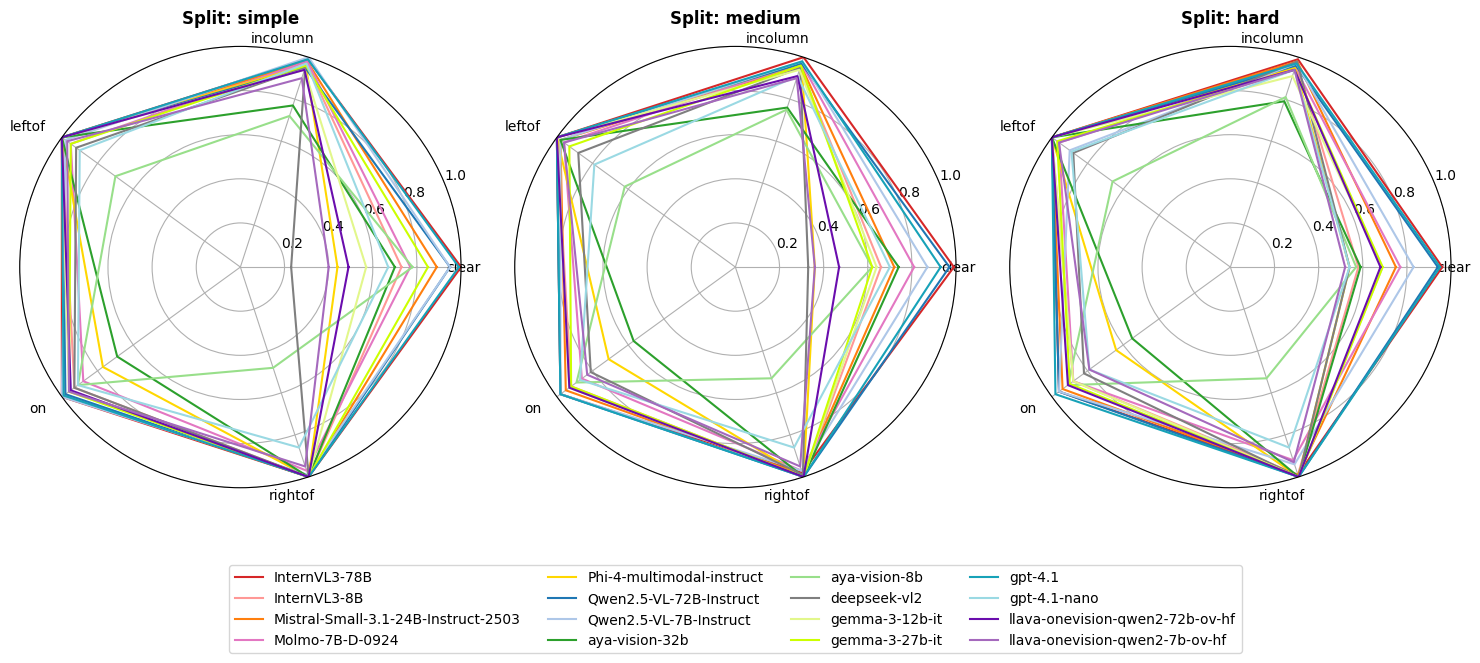

In [44]:
plot_predicate_accuracy_radar(blocksworld_per_predicate_no_cot_df, filename="blocksworld_no_cot_predicate_accuracy_radar")

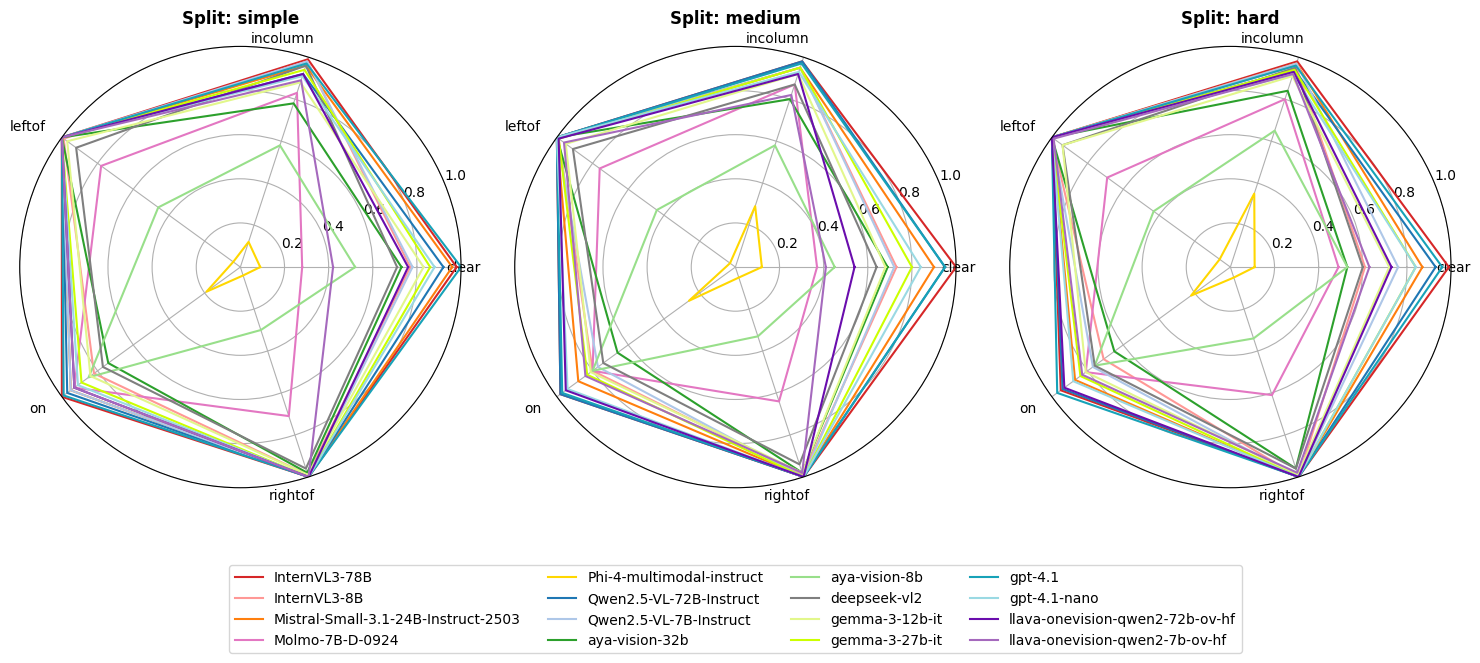

In [45]:
plot_predicate_accuracy_radar(blocksworld_per_predicate_cot_df, filename="blocksworld_cot_predicate_accuracy_radar")

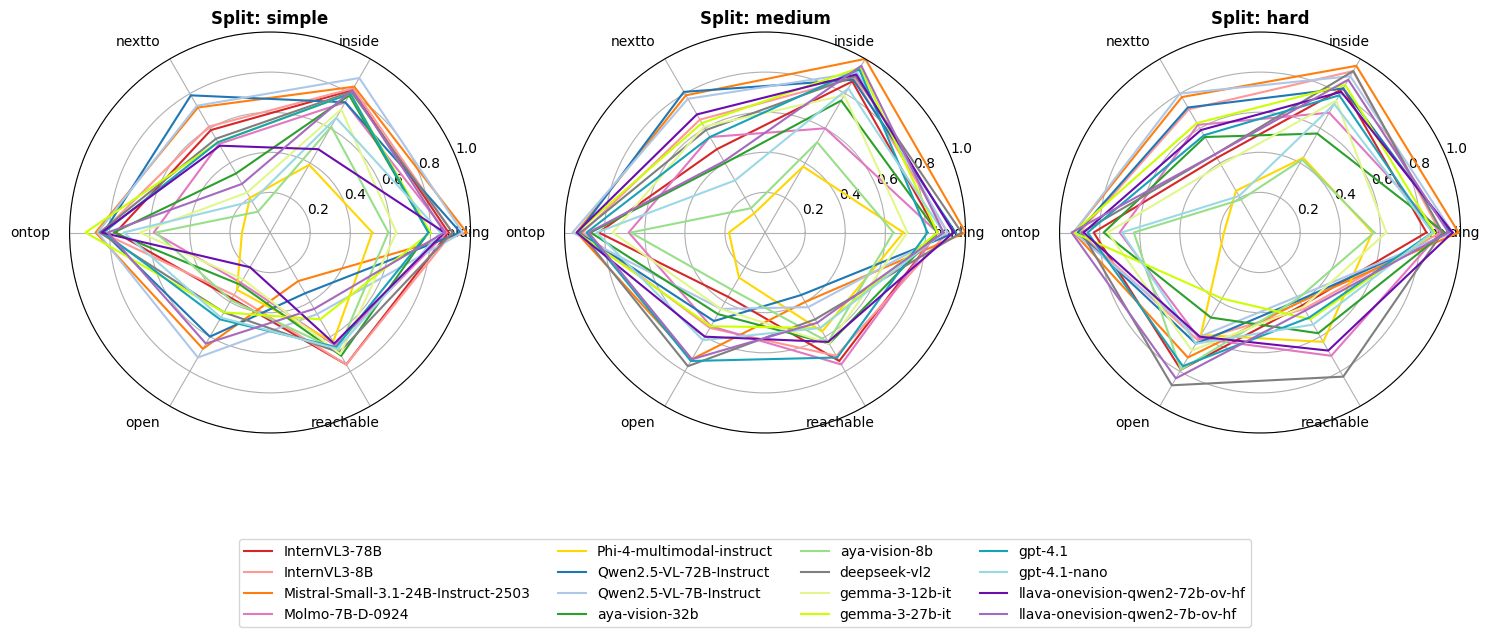

In [46]:
plot_predicate_accuracy_radar(igibson_per_predicate_no_cot_df, filename="igibson_no_cot_predicate_accuracy_radar")

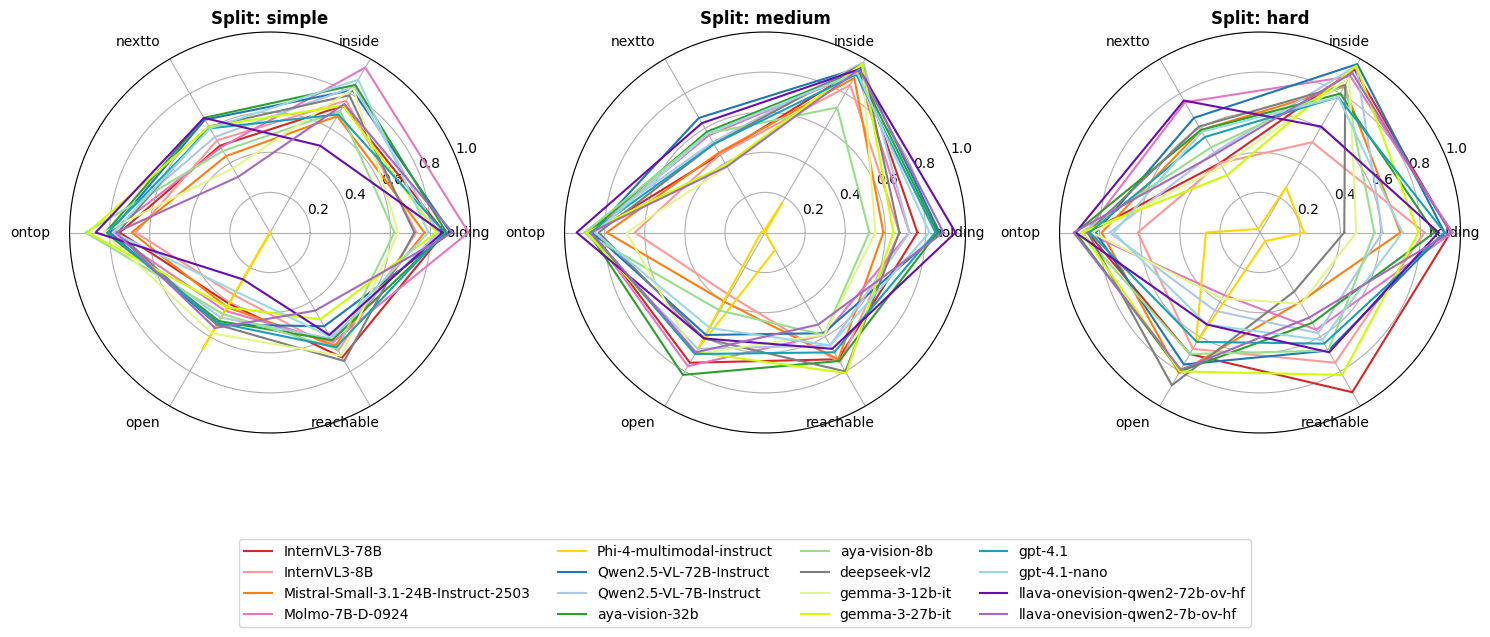

In [47]:
plot_predicate_accuracy_radar(igibson_per_predicate_cot_df, filename="igibson_cot_predicate_accuracy_radar")